In [1]:
import pandas as pd
from statistics import mean, stdev
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm import tqdm
from pandarallel import pandarallel

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
# Setting working directory
import json
with open('setup.json', 'r') as openfile:
    setup_object = json.load(openfile)
    WD = setup_object["wd_path"]
    dataset_path = setup_object["dataset_path"]

In [4]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [5]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI']

In this study we delve into the analysis of network flows captured by the NFStream tool. Positioned at the edge of residential or SOHO networks, NFStream processes in-transit network traffic. Among a high amount of metrics that this tool can measure, our research emphasizes the early flow characteristics. These pertain to features documented exclusively at the beginning of the flow at the packet level, including packet size, packet direction (either towards the flow source or towards the destination), and packet inter-arrival times (PIAT). It's imperative to note that the monitoring duration for these features is limited, ensuring there's no detrimental impact on network performance. Once this observation window concludes, flow processing transitions from the software layer to hardware accelerators, optimizing processing speed. This transition ensures maximal throughput and minimal processing overhead, resulting in moderate resource utilization.

Our research scope is confined to LAN delays, representing the latency experienced within the LAN domain of the network. We've opted for this narrowed focus because WAN-side delays may appear due to various diverse factors and exerting control over them is challenging. Future work might encompass an extension to WAN scenarios if this study proves promising.

# Data Characteristics

The dataset used in our analysis and methodology validation is network traffic data from a university dormitory network in Central Europe. The topology of the network is presented in the figure below.

![Topology](images/topology_high_level.svg)

The figure shows a high level view of the network, i.e. the exact nature of the network connections, switches and additional routers are abstracted to lines. We also omit to show the topology inside buildings. The figure shows that there are 3 primary locations which are covered by the dormitory network. These locations are based on grouping of dormitory buildings by their physical proximity. The distance among buildings at the same location are around a few hundred meters (lower than a kilometer). *Location 1* is located at the university premises as the UPLINK router where NFStream monitored the traffic. *Location 2* sits a couple of kilometers away on the outskirts of the city (whereas the university is in the center). *Location 3* is in a different town altogether, with the connection passing through mulitple hops (represented by the dotted line in the figure).

NFStream measured the captured traffic at the edge of the network. The PIAT measured by this tool is the time elpased between when a packet arrives at the UPLINK router from the WAN side and consecutive answer packet arrives from the LAN side. Therefore the PIAT value is influenced by the distance of the end-device form the observation point. As this varies from location to location, it is important to separate the traffic based on this metric.

NFStream was run with the following settings:

- `decode_tunnels=False` *tunneled traffic was not decoded*
- `bpf_filter="ip and tcp"` ***only IPv4 TCP** traffic was captured (see reasons later)*
- `idle_timeout=120` *all flows were expired after no activity was recorded for ***2 minutes*** after receiving the last packet*
- `active_timeout=1800` *all flows were expired regardless of activity after ***30 minutes****
- `accounting_mode=1` *IP-layer accounting was used (the reported packet sizes are the IP packet size)*
- `udps=TCPFlowExpiryPlugin()` *an NFPlugin was utilized for custom expiration (see below)*
- `n_dissections=20` *nDPI may use up to 20 packets to dissect for L7 visibility and determine the application used and other client and server specific information*
- `statistical_analysis=True` *post mortem statistical features like ***packet size***, ***PIAT***, ***packets with various TCP flags*** were analyzed and statistical features (min, max, mean, std. dev.) was calculated in both the source to destination and the opposing direction, as well as the two directions combined*
- `splt_analysis=255` *for the early statistical features that are packet level 255 packets were recorded, this acts as the base of our analysis*
- `n_meters=1` *1 core was used for processing as this provides stable behavior for the current version of NFStream*

Other variables were left on default settings. The custom TCP expiration utilized expires the flows naturally according to the TCP connection termination three-way handshake, i.e. (I for *initiator* and R for *receiver*)

>I  &ndash;&ndash;&ndash;&ndash; FIN &ndash;&ndash;&ndash;&ndash;>&nbsp;&nbsp;R<br/>
I  <&ndash;&ndash; FIN,ACK &ndash;&ndash;&nbsp;&nbsp;R<br/>
I  &ndash;&ndash;&ndash;&ndash; ACK &ndash;&ndash;&ndash;&ndash;>&nbsp;R

This means if there are 2 FIN packets in the flow, the current packet does not carry one of these FINs but does an ACK, the flow should be terminated.
If the flow starts with a FIN or a RST packet, that specific flow should be terminated as well. The following NFPlugin accomplishes the desired behavior.

```python
class TCPFlowExpiryPlugin(NFPlugin):
    """
    Custom NFPlugin to expire TCP flows based on RST or FIN flags.
    """

    def on_init(self, packet, flow):
        # Set the expiration ID based on TCP RST or FIN flags.
        if packet.fin:
            flow.expiration_id = -1
        if packet.rst:
            flow.expiration_id = -1

    def on_update(self, packet, flow):
        # Update expiration policy based on TCP RST or FIN flags.
        if flow.bidirectional_fin_packets == 2 and not packet.fin and packet.ack:
            flow.expiration_id = -1
        if packet.rst:
            flow.expiration_id = -1
```

*Note: the plugin does not terminate the flow if there is a communication fail between the two parties during the handshake (the FIN packet needs to be repeated). In this case the retransmission attempts are also recorded in the flow and may indicate possible service degradation.*

IP addresses and MAC addresses count as personal data (under GDPR) when they could be used to identify a particular person. As these addresses in the university dormitory network belong to specific students, using additional information the flows may be paired to a specific person. Therefore we choose to anonymize the IP address and MAC addresses. Instead of using the `columns_to_anonymize` variable of NFStream this was done post-flow-capture in order to extract additional flow information. The hashing was done identically to NFStream using the *blake2b* hashing algorithm with a 64 byte-long secret.

The IP range information was used for the following feature extraction. The location of the flow (i.e. identifying the block the flow originated from or was addressed to) was added based on the IP range of that specific flow. Additionally, while we expect that the majority of the connections are set up by the measured dormitory network (i.e. the LAN hosts are the source), there may be a few instances where the LAN stands on the destination side of the traffic (e.g.: for connections to servers that run inside the LAN or even potential attack scenarios from the outside). These type of flows have their statistics flipped, i.e. for LAN originated traffic `src2dst` metrics mean *from LAN to WAN*, however, for WAN originated traffic the `dst2src` describes the same *from LAN to WAN* behavior. Therefore, in addition to the location identifier we mark whether the flow is of reverse kind in a new column. We can also mark whether the traffic generator host connected to the network wirelessly or with a wired connection using the available address policy.

In [6]:
# Read the datasets (only the columns we will be needing)

dfs = []
for day in days:
    dfs.append(pd.read_parquet(dataset_path + f'/{day}.parquet', columns=['id', 'expiration_id', 'src_ip', 'dst_ip', 'protocol',
                                                                          'ip_version', 'vlan_id', 'bidirectional_first_seen_ms',
                                                                          'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
                                                                          'bidirectional_packets', 'bidirectional_bytes', 'src2dst_bytes',
                                                                          'dst2src_bytes', 'splt_direction', 'splt_ps', 'splt_piat_ms',
                                                                          'application_name', 'application_category_name', 'application_confidence',
                                                                          'location', 'connection_type', 'reversed']))

---

NFStream does not sort the expired flows in the order of starting time. For the analysis this sort is necessary.

In [7]:
for df in tqdm(dfs):
    df.sort_values(by='bidirectional_first_seen_ms', inplace=True)
    df.reset_index(drop=True, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]


## Temporal Characteristics

Let's start by analyzing the temporal features of the trace. These include the temporal span of the dataset, the flow arrival-rate per unit time and the observed throughput during the measurement.

In [8]:
for idx, df in enumerate(dfs):
    print(days[idx])
    print(f"Start of the measurement: {pd.to_datetime(df['bidirectional_first_seen_ms'].iloc[0], unit='ms')}")
    print(f"End of the measurement: {pd.to_datetime(df['bidirectional_last_seen_ms'].iloc[-1], unit='ms')}")
    print(f"The whole timespan of the data: {(df['bidirectional_last_seen_ms'].iloc[-1] - df['bidirectional_first_seen_ms'].iloc[0]) / 1000 / 60 :.2f} minutes")
    print()

MON
Start of the measurement: 2024-01-15 19:24:40.576000
End of the measurement: 2024-01-15 20:18:29.102000
The whole timespan of the data: 53.81 minutes

TUE
Start of the measurement: 2024-01-16 19:34:09.274000
End of the measurement: 2024-01-16 20:16:14.412000
The whole timespan of the data: 42.09 minutes

WED
Start of the measurement: 2024-01-17 19:26:35.087000
End of the measurement: 2024-01-17 20:18:01.326000
The whole timespan of the data: 51.44 minutes

THU
Start of the measurement: 2024-01-18 19:20:36.430000
End of the measurement: 2024-01-18 20:15:01.059000
The whole timespan of the data: 54.41 minutes

FRI
Start of the measurement: 2024-01-19 19:20:35.462000
End of the measurement: 2024-01-19 20:15:01.351000
The whole timespan of the data: 54.43 minutes



The network traffic was measured during a week during the evening at approximately the same time with similar duration (40-50 minutes). The exact duration depends on the quantity of the measured traffic that day.

In [9]:
flow_counts = []
for idx, df in enumerate(dfs):
    df['start_second'] = df['bidirectional_first_seen_ms'] // 1000
    df['start_time_aggr'] = pd.to_datetime(df['start_second'] * 1000, unit='ms')
    # Count the number of flows starting each second
    flow_counts.append(df['start_time_aggr'].value_counts().sort_index())

In [10]:
# Calculate statistics
for idx, df in enumerate(dfs):
    print(days[idx])
    min_flows = flow_counts[idx].min()
    max_flows = flow_counts[idx].max()
    avg_flows = flow_counts[idx].mean()
    std_dev_flows = flow_counts[idx].std()
    
    # Print statistics
    print(f"Minimum Flows per Second: {min_flows}")
    print(f"Maximum Flows per Second: {max_flows}")
    print(f"Average Flows per Second: {avg_flows:.2f}")
    print(f"Standard Deviation of Flows per Second: {std_dev_flows:.2f}")
    print()

MON
Minimum Flows per Second: 78
Maximum Flows per Second: 3469
Average Flows per Second: 986.20
Standard Deviation of Flows per Second: 247.48

TUE
Minimum Flows per Second: 312
Maximum Flows per Second: 3511
Average Flows per Second: 994.92
Standard Deviation of Flows per Second: 270.75

WED
Minimum Flows per Second: 385
Maximum Flows per Second: 3766
Average Flows per Second: 1001.83
Standard Deviation of Flows per Second: 241.20

THU
Minimum Flows per Second: 70
Maximum Flows per Second: 3199
Average Flows per Second: 827.91
Standard Deviation of Flows per Second: 228.51

FRI
Minimum Flows per Second: 319
Maximum Flows per Second: 2651
Average Flows per Second: 877.04
Standard Deviation of Flows per Second: 322.27



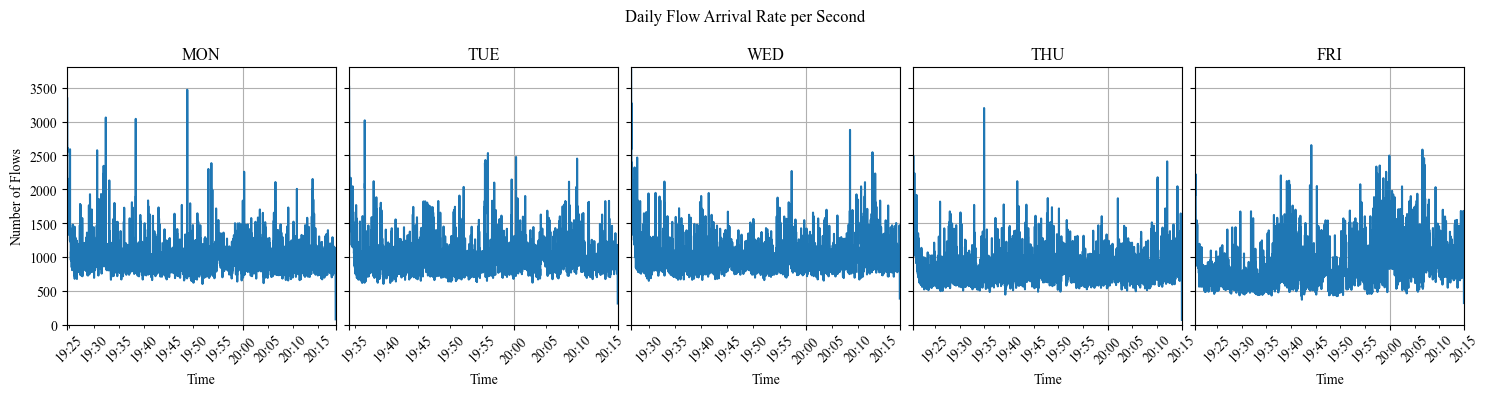

In [11]:
# Plot the flow arrival rate
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    flow_counts[idx].plot(kind='line', ax=a)
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('')   
    a.set_ylim(0, 3800)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Number of Flows')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])
        
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/flow_arr_rate.pdf')
fig.suptitle('Daily Flow Arrival Rate per Second')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The plots show considerable variation in the flow arrival rate. The patterns are similar throughout the week with an average arrival rate around 900-1000 flows per second and the standard deviation being around 250. There are several pronounced spikes, with the most significant peaks reaching over 3500 flows per second. These spikes suggest moments of high activity or bursts in flow arrivals. Between these peaks, the flow rate varies but generally stays below 1500 flows per second. Wednesday and Friday saw lower bursts arrival rates but the average was similar. This suggests that the data in terms of this factor is comparable.

The overall pattern suggests intermittent periods of high activity amidst a more steady or lower rate of flow arrivals. The reasons behind these patterns could be due to various factors such as network usage patterns, scheduled events (like database updates), or anomalies in the system being monitored. The peaks serve as potential points of Service Degradation in time.

### Data Throughput Rate

In [12]:
# Sum the bytes for each second, convert to MiB
data_rate_per_second = []
for idx, df in enumerate(dfs):
    data_rate_per_second.append(df.groupby('start_time_aggr')['bidirectional_bytes'].sum() / 1024 / 1024)

In [13]:
# Calculate statistics
for idx, df in enumerate(dfs):
    print(days[idx])
    min_rate = data_rate_per_second[idx].min()
    max_rate = data_rate_per_second[idx].max()
    avg_rate = data_rate_per_second[idx].mean()
    std_dev_rate = data_rate_per_second[idx].std()
    
    # Print statistics
    print(f"Minimum Data Rate per Second: {min_rate} MiBps")
    print(f"Maximum Data Rate per Second: {max_rate} MiBps")
    print(f"Average Data Rate per Second: {avg_rate:.2f} MiBps")
    print(f"Standard Deviation of Data Rate per Second: {std_dev_rate:.2f} MiBps")
    print()

MON
Minimum Data Rate per Second: 0.05867290496826172 MiBps
Maximum Data Rate per Second: 78087.2298707962 MiBps
Average Data Rate per Second: 243.49 MiBps
Standard Deviation of Data Rate per Second: 1475.07 MiBps

TUE
Minimum Data Rate per Second: 0.809107780456543 MiBps
Maximum Data Rate per Second: 108118.77271938324 MiBps
Average Data Rate per Second: 307.21 MiBps
Standard Deviation of Data Rate per Second: 2322.29 MiBps

WED
Minimum Data Rate per Second: 1.2242069244384766 MiBps
Maximum Data Rate per Second: 73567.14877700806 MiBps
Average Data Rate per Second: 254.69 MiBps
Standard Deviation of Data Rate per Second: 1517.05 MiBps

THU
Minimum Data Rate per Second: 0.08066558837890625 MiBps
Maximum Data Rate per Second: 137937.1560459137 MiBps
Average Data Rate per Second: 244.64 MiBps
Standard Deviation of Data Rate per Second: 2541.15 MiBps

FRI
Minimum Data Rate per Second: 0.3238554000854492 MiBps
Maximum Data Rate per Second: 83792.43410015106 MiBps
Average Data Rate per Seco

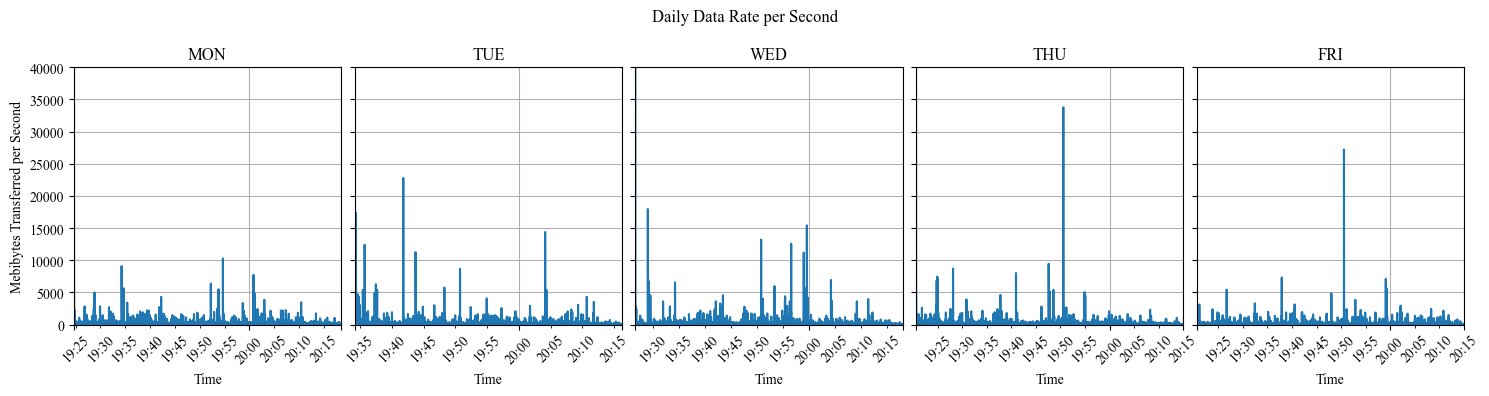

In [14]:
# Plot the data rate
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    data_rate_per_second[idx].plot(kind='line', ax=a)
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_ylim(0, 40000)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Mebibytes Transferred per Second')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/data_rates.pdf')
fig.suptitle('Daily Data Rate per Second')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The Data Rate plot shows that for the most part, the data transfer rate is relatively low, often below 5,000 MiBps. However, there are notable exceptions where the rate spikes dramatically, exceeding even 30,000 MiBps at the highest points around 19:50 on Thursday, with a second prominance at the same time a day later (possible due to the same cause). These spikes are abrupt and appear to be short-lived, indicating brief moments of very high data transfer activity. After these peaks, the rate drops back down to the lower baseline level. The Data Rate among the days observes similar averages between 200-300 MiBps with a standard deviation betwee 1400 and 2400 MiBps.

The distribution and height of the spikes suggest irregular and possibly unpredictable bursts in data transmission, which could be due to scheduled data transfers, network backups, streaming of high-definition media, or some other processes that require high bandwidth. The consistency of low rates outside of these spikes indicates a network that is relatively quiet aside from these moments of high activity.

The Flow Arrival rate and the Data Rate does not seem to be closely correlated. Although both metrics observe spikes, these are experienced at different times. The data rate is high when the flow arrival rate is at a normal level and vice versa. A high amount of transferred bytes along with a relatively low amount of flows may even indicate an attack scenario as well.

#### Inbound and Outbound Data Rates

In [15]:
# Bulding True LAN-WAN characteristics

for df in tqdm(dfs):
    df['LAN2WAN_bytes'] = df.apply(lambda row: row['dst2src_bytes'] if row['reversed'] else row['src2dst_bytes'], axis=1)
    df['WAN2LAN_bytes'] = df.apply(lambda row: row['src2dst_bytes'] if row['reversed'] else row['dst2src_bytes'], axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [11:17<00:00, 135.43s/it]


In [16]:
# Sum the bytes for each second, convert to MiB
data_rate_per_second_upload = []
data_rate_per_second_download = []
for idx, df in enumerate(dfs):
    data_rate_per_second_upload.append(df.groupby('start_time_aggr')['LAN2WAN_bytes'].sum() / 1024 / 1024)
    data_rate_per_second_download.append(df.groupby('start_time_aggr')['WAN2LAN_bytes'].sum() / 1024 / 1024)

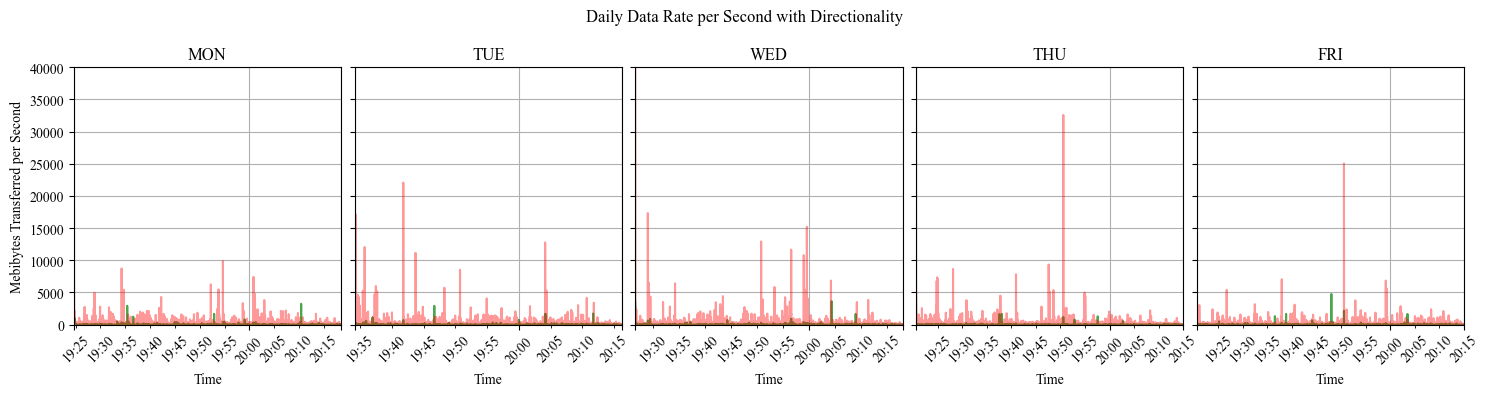

In [17]:
# Plot the data rate
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    data_rate_per_second_upload[idx].plot(kind='line', color='green', alpha=0.7, label='Upload (Outbound) Data Rate', ax=a)
    data_rate_per_second_download[idx].plot(kind='line', color='red', alpha=0.4, label='Download (Inbound) Data Rate', ax=a)
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_ylim(0, 40000)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Mebibytes Transferred per Second')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/data_rates_directional.pdf')
fig.suptitle('Daily Data Rate per Second with Directionality')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

Observing the data rate experienced in either direction (corresponding to inbound and outbound traffic) we see the data rate spike around 19:50 on Thursday and Friday corresponds to Inbound traffic almost in its entirity. We see the same for all the other notable spikes in the data. This suggests a high amount of downloaded data. with a negligible amount of Outbound traffic, i.e. a low amount of uploads.

### Packet Count Characteristics

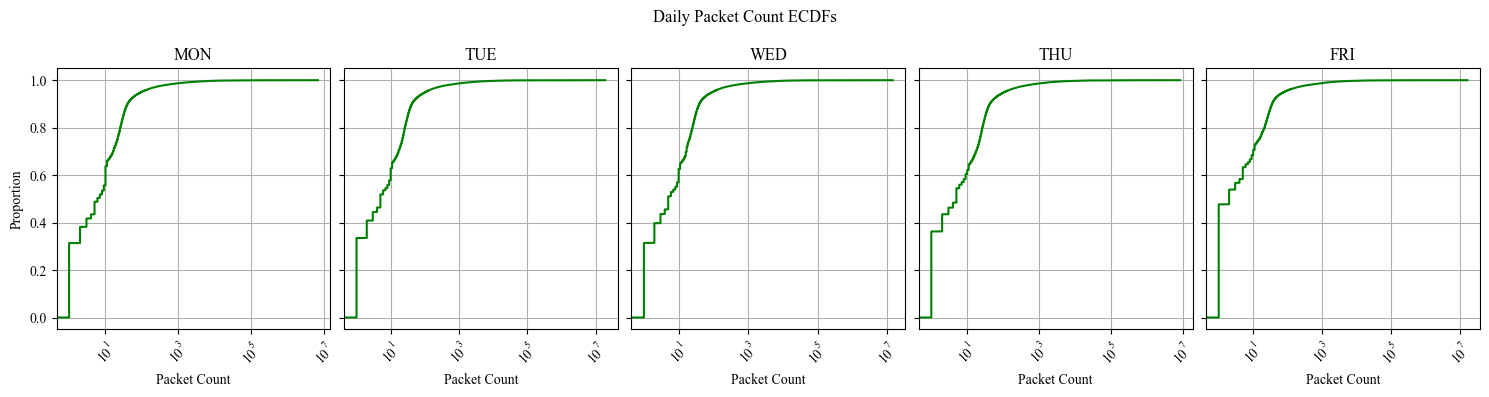

In [18]:
# Packet count ECDF-plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    packet_count_ecdf = ECDF(df['bidirectional_packets'])
    a.plot(packet_count_ecdf.x, packet_count_ecdf.y, color='green', ls='-')
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Packet Count')
    if idx == 0:
        a.set_ylabel('Proportion')
    a.set_xscale('log')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/packet_count_ecdf.pdf')
fig.suptitle('Daily Packet Count ECDFs')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The Cumulative Distribution Plot (CDF) of the Packet Counts shows that the vast majority of the flow (over 90%) has less than a 100 packets, resulting in short flows. Furthermore, more than a quarter of all flows have just one packet (around a half for Friday). These short flows are unsuitable for our analysis and therefore will be dropped. Only a small proportion of the measured flows are long in terms of packet count with a few reaching up to millions of packets. The packet count statistics show high similarity throughout the week.

### Flow Size (Cumulative Bytes) Characteristics

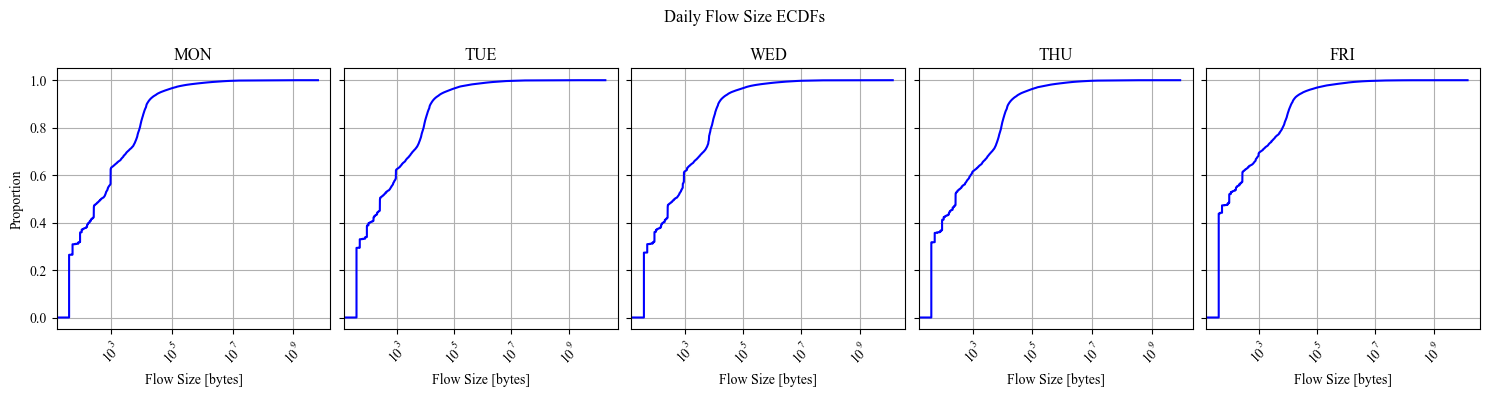

In [19]:
# Packet count ECDF-plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    flow_size_ecdf = ECDF(df['bidirectional_bytes'])
    a.plot(flow_size_ecdf.x, flow_size_ecdf.y, color='blue', ls='-')
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow Size [bytes]')
    if idx == 0:
        a.set_ylabel('Proportion')
    a.set_xscale('log')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/flow_size_ecdf.pdf')
fig.suptitle('Daily Flow Size ECDFs')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

This CDF show the cumulative bytes for all flows (the sum of all its packet's sizes). We see a similar, although a more gradual pattern than with packet count. Almost 40% of the flows contain less then 100 bytes in total on all days, while over 90% consists of 10 KB of data at max.

### Flow Duration Characteristics

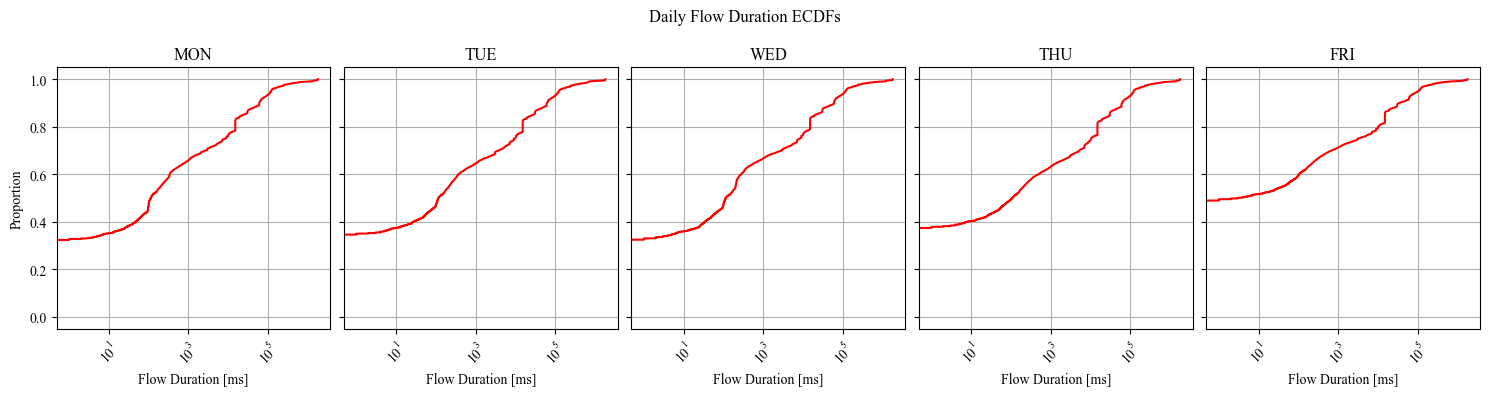

In [20]:
# Packet count ECDF-plot
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    flow_duration_ecdf = ECDF(df['bidirectional_duration_ms'])
    a.plot(flow_duration_ecdf.x, flow_duration_ecdf.y, color='red', ls='-')
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow Duration [ms]')
    if idx == 0:
        a.set_ylabel('Proportion')
    a.set_xscale('log')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/flow_duration_ecdf.pdf')
fig.suptitle('Daily Flow Duration ECDFs')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The Flow Duration CDF shows that the small flows (in terms of packet count and size) correspond to short duration as well. However, contrary to earlier plots, this one portrays that in terms of flow duration there is a gradual increase. The longest flows are over 15 minutes but these are not multiple orders of magnitude longer than the majority of the flows.

In [21]:
all_dfs = pd.concat(dfs)

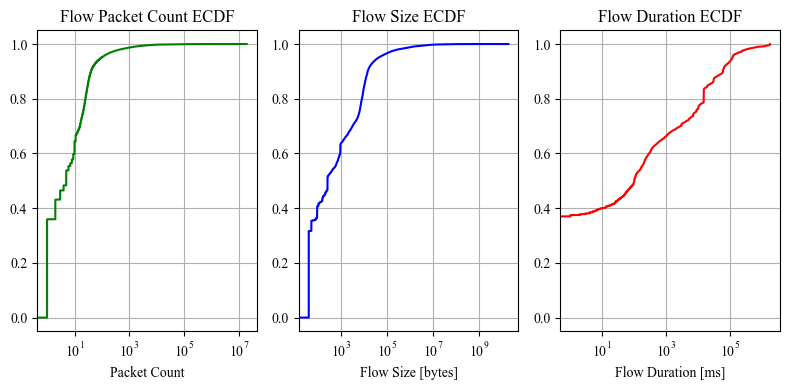

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

packet_count_ecdf = ECDF(all_dfs['bidirectional_packets'])
axs[0].plot(packet_count_ecdf.x, packet_count_ecdf.y, color='green', ls='-')
axs[0].set_xscale('log')
axs[0].grid(True)
axs[0].set_xlabel('Packet Count')
axs[0].set_title('Flow Packet Count ECDF')

flow_size_ecdf = ECDF(all_dfs['bidirectional_bytes'])
axs[1].plot(flow_size_ecdf.x, flow_size_ecdf.y, color='blue', ls='-')
axs[1].set_xscale('log')
axs[1].grid(True)
axs[1].set_xlabel('Flow Size [bytes]')
axs[1].set_title('Flow Size ECDF')

flow_duration_ecdf = ECDF(all_dfs['bidirectional_duration_ms'])
axs[2].plot(flow_duration_ecdf.x, flow_duration_ecdf.y, color='red', ls='-')
axs[2].set_xscale('log')
axs[2].grid(True)
axs[2].set_xlabel('Flow Duration [ms]')
axs[2].set_title('Flow Duration ECDF')

plt.tight_layout()
plt.savefig('plots/preprocessing/aggregated_ecdfs.pdf')
plt.show()

---

Since our goal is to analyze delays resulting in SD events in flows we have no use for very short flows, therefore flows with fewer than 2 packets (i.e. no response was received/sent) are dropped.

nDPI was used for flow dissection and among multiple metrics application name and application category determination. nDPI indicates with a number the confidence level at which this categorization was carried out. A higher number indicates higher confidence. Level 6 means the categorization was done by Deep Packet Inspection, i.e. instead of heuristics (like port based approach or correlation based on earlier sessions) the information in flow packets indicated the application type. The application category metric is crucial for our analysis because a per application category analysis is to be carried out as well as inter-category relationships explored. For this reason only Level 6 confidence level (the highest supported by the current version of NFStream) flows were kept.

In [23]:
df_filtereds = []

for df in dfs:
    df_filtered = df[df['bidirectional_packets'] > 2]
    df_filtered = df_filtered[df_filtered['application_confidence'] == 6]
    df_filtereds.append(df_filtered)

In [24]:
for day, df, df_filtered in zip(days, dfs, df_filtereds):
    print(day)
    print(f'Flow count in the original dataset: {len(df)}')
    print(f'Flow count in the filtered dataset: {len(df_filtered)}')
    print(f'Dropped flows: {len(df) - len(df_filtered)}')
    print(f'Proportion of the filtered dataset to the original one: {len(df_filtered) / len(df)}')
    print()

MON
Flow count in the original dataset: 3185436
Flow count in the filtered dataset: 1464421
Dropped flows: 1721015
Proportion of the filtered dataset to the original one: 0.4597238808125481

TUE
Flow count in the original dataset: 2513156
Flow count in the filtered dataset: 1097956
Dropped flows: 1415200
Proportion of the filtered dataset to the original one: 0.4368833450848256

WED
Flow count in the original dataset: 3092647
Flow count in the filtered dataset: 1400967
Dropped flows: 1691680
Proportion of the filtered dataset to the original one: 0.45299932388015834

THU
Flow count in the original dataset: 2703948
Flow count in the filtered dataset: 1089312
Dropped flows: 1614636
Proportion of the filtered dataset to the original one: 0.4028598183101154

FRI
Flow count in the original dataset: 2865281
Flow count in the filtered dataset: 923214
Dropped flows: 1942067
Proportion of the filtered dataset to the original one: 0.32220714128910916



After the filtering step around 40% of the flows were kept for Monday-Thursday and 32% for the traffic on Friday.

In [25]:
dfs = df_filtereds

In [26]:
all_dfs = pd.concat(dfs)

We are going to focus on the delays experienced in the LAN-side of the network. There are multiple subnets in the measured network. LAN traffic may be analyzed in single subnets looking for simultaneously occurring Service Degradation events. The sepearate analysis of subnets is important in order to determine the network segment effected by the SD event. Another similar approach is to analyze the traffic on a host-by-host basis and inspect overlaps. This warrants the retention of the IP address fields.

## Feature Characteristics
Let's analyze the distribution of the remaining categorical and numerical non complex columns

### Host Distribution

In [27]:
# Bulding True LAN-WAN characteristics
for df in dfs:
    df['LAN_host'] = df.apply(lambda row: row['dst_ip'] if row['reversed'] else row['src_ip'], axis=1)

In [28]:
for idx, df in enumerate(dfs): 
    print(days[idx])
    print(df[['LAN_host']].value_counts()[:5])
    print()

MON
LAN_host                                                                                                                        
6092943a40db1a1f384aeb9a1b9e815555c4ab2df3868b38fa60e3664237781ad6f459bd0a150565f11e0858ddd5e731345d3ca847df9ab6b402689d49c48f40    201919
ed82a694d2b49ace7270bd318c556ff7fa00f7c72fd8716f99f092f3c6ecdd679588c083b487c11ab883d876abe40cfafa302c54f2944637ec46694cf43c389a     17140
34973ef28ae178c84fb6e2e65a9bb70ea7ffe3d638f40cf8b3df1dc8554b088e7ec234a3f2080e446044ccc7f0df576dc3d9c25218f485a08b3801231beaa68e      9658
ff4ae5e411fa9250fcb66527074882dfdb3704f66240cd336155cb09bbf1d92cdfad09d346886feb4bf427187eb3b4683a976e0bc53c5a4664aa001f25d608b9      9071
683c5b701fd98014d286dbd4cc7fdda248f486e9888a19fe0c38b06efc1e04df100f470b7562e39418094ceccdf9a41ae27f26325870ac53009b6f791b3dc0ce      5921
Name: count, dtype: int64

TUE
LAN_host                                                                                                                        
6092943a40db

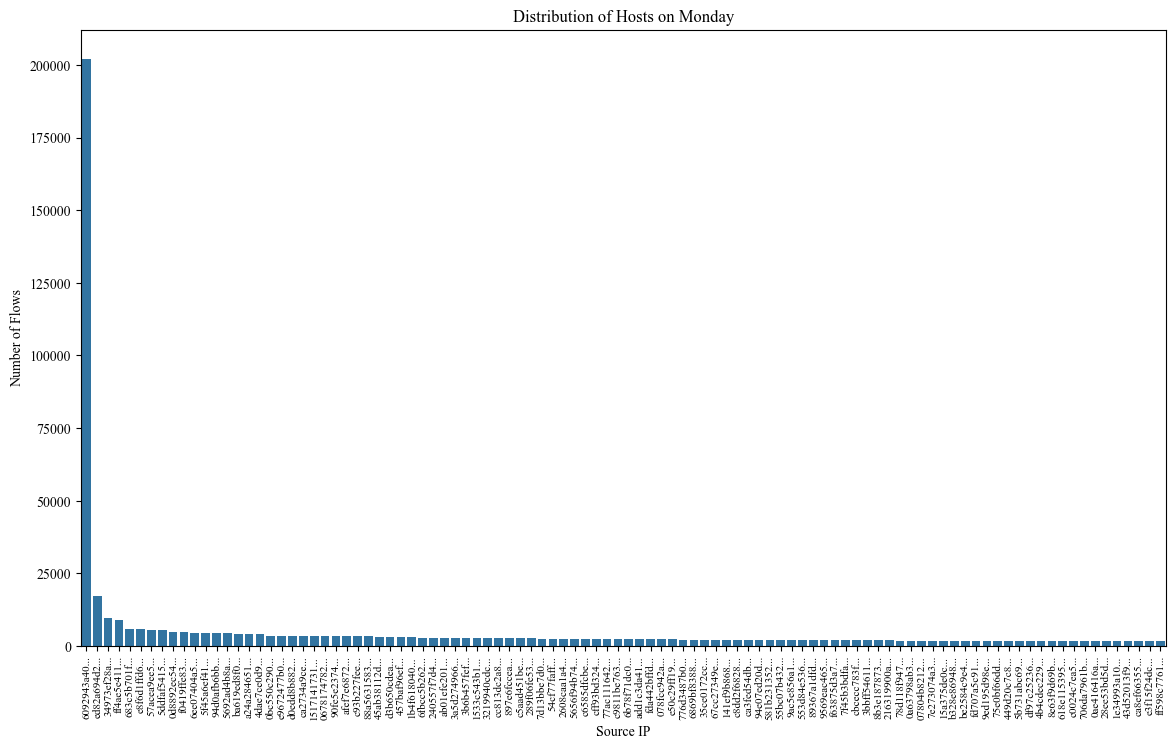

In [29]:
top_hosts = dfs[0]['LAN_host'].value_counts().head(100).index
df_top_100_hosts = dfs[0][dfs[0]['LAN_host'].isin(top_hosts)]
plt.figure(figsize=(14, 8))
sns.countplot(data=df_top_100_hosts, x='LAN_host', order=df_top_100_hosts['LAN_host'].value_counts().index)
plt.title('Distribution of Hosts on Monday')
plt.xlabel('Source IP')
plt.ylabel('Number of Flows')
labels = [f'{s[:10]}...' for s in top_hosts.to_list()]
plt.xticks(range(len(top_hosts)), labels, rotation='vertical', fontsize=8)
plt.show()

By identifying hosts by IP address (note that there may be mulitple host hidden behind an IP address on a subnet using NAT) we see that there is 1 prominent host that initiate over 200,000 flows on Monday only (also leading on other days). For the rest of the hosts we see a steady but slow decrease in flow number until we get to the hosts that only exchanged a handful of flows. This indicates that this (and a few other hosts) take a substantially higher share of the network traffic, than other host. These host may run servers that are accessible from the outside or run applications that generate a higher number of flows than other types of traffic.

#### Distribution of Traffic for the Leading 5 Hosts

Let's further examine the traffic characteristics for the 5 hosts that generate more than 10000 flows each.

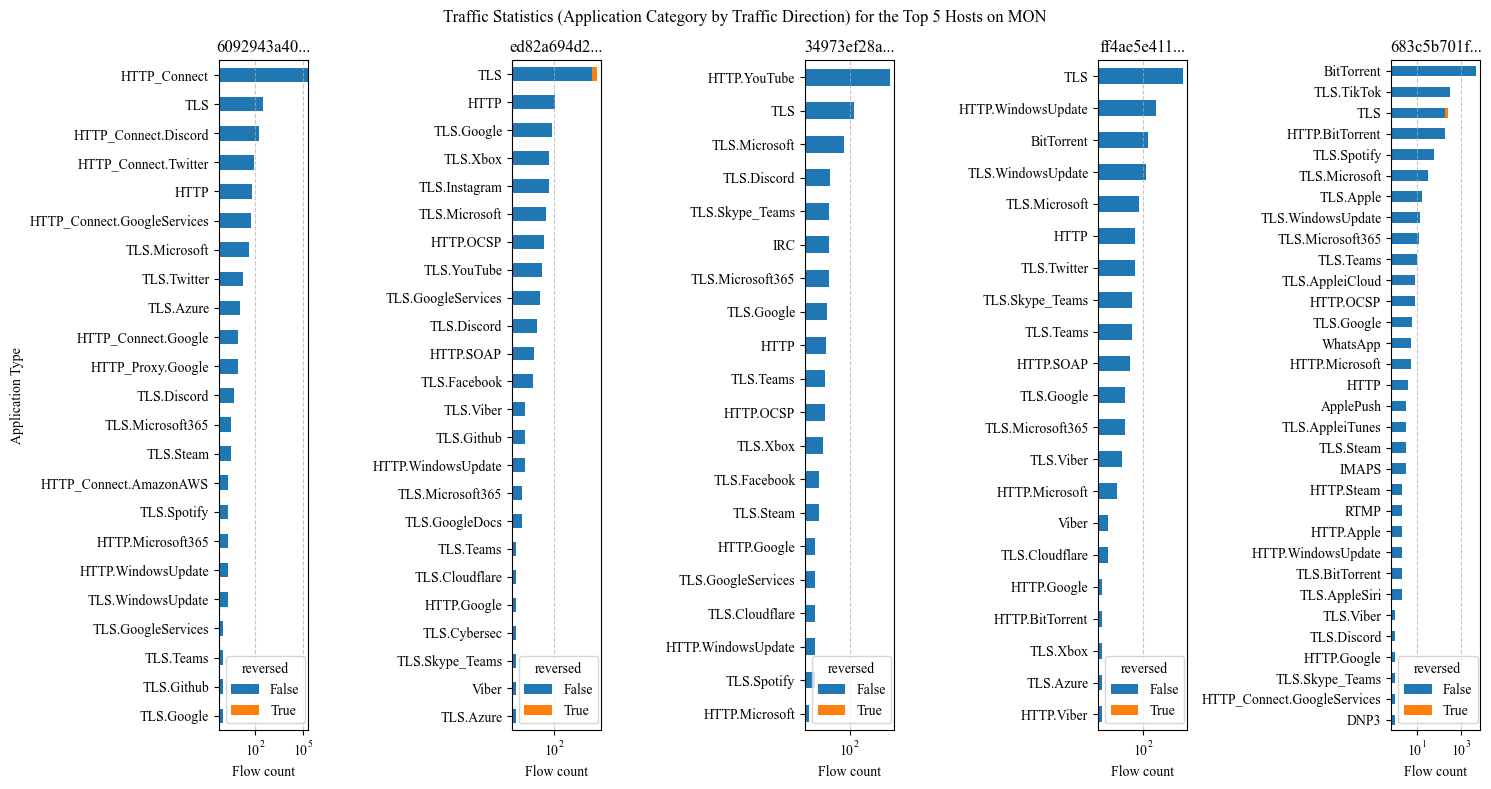

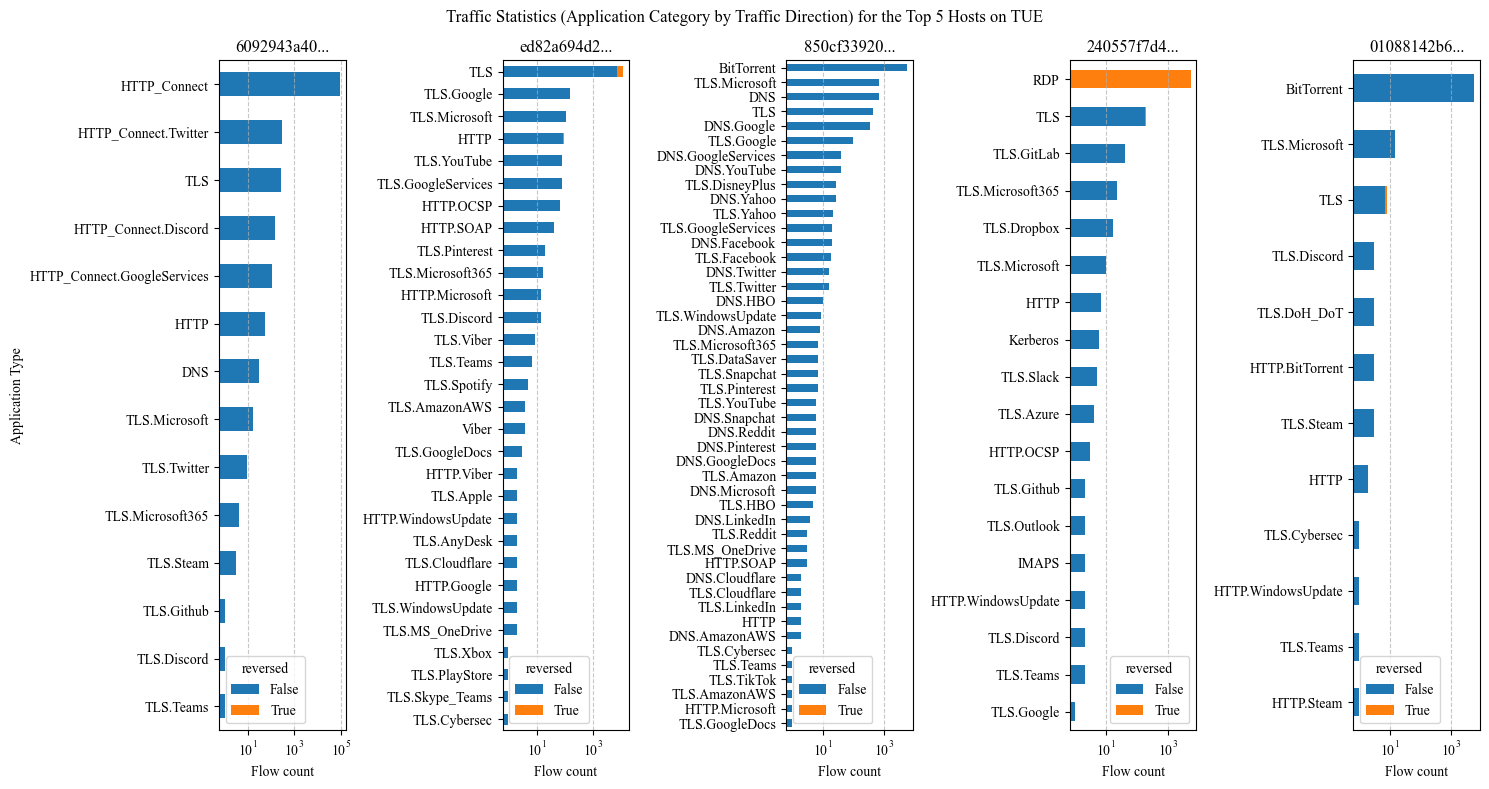

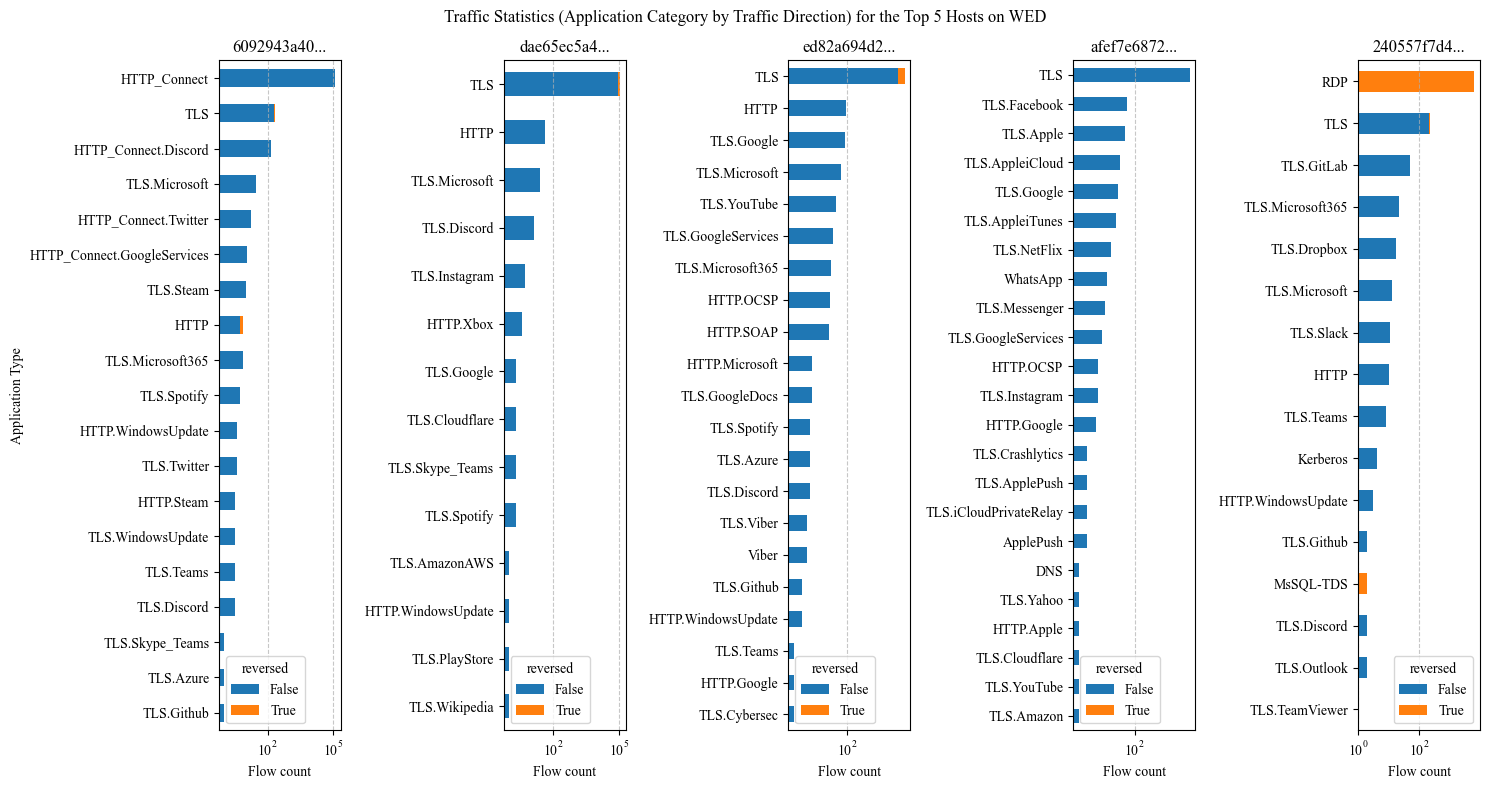

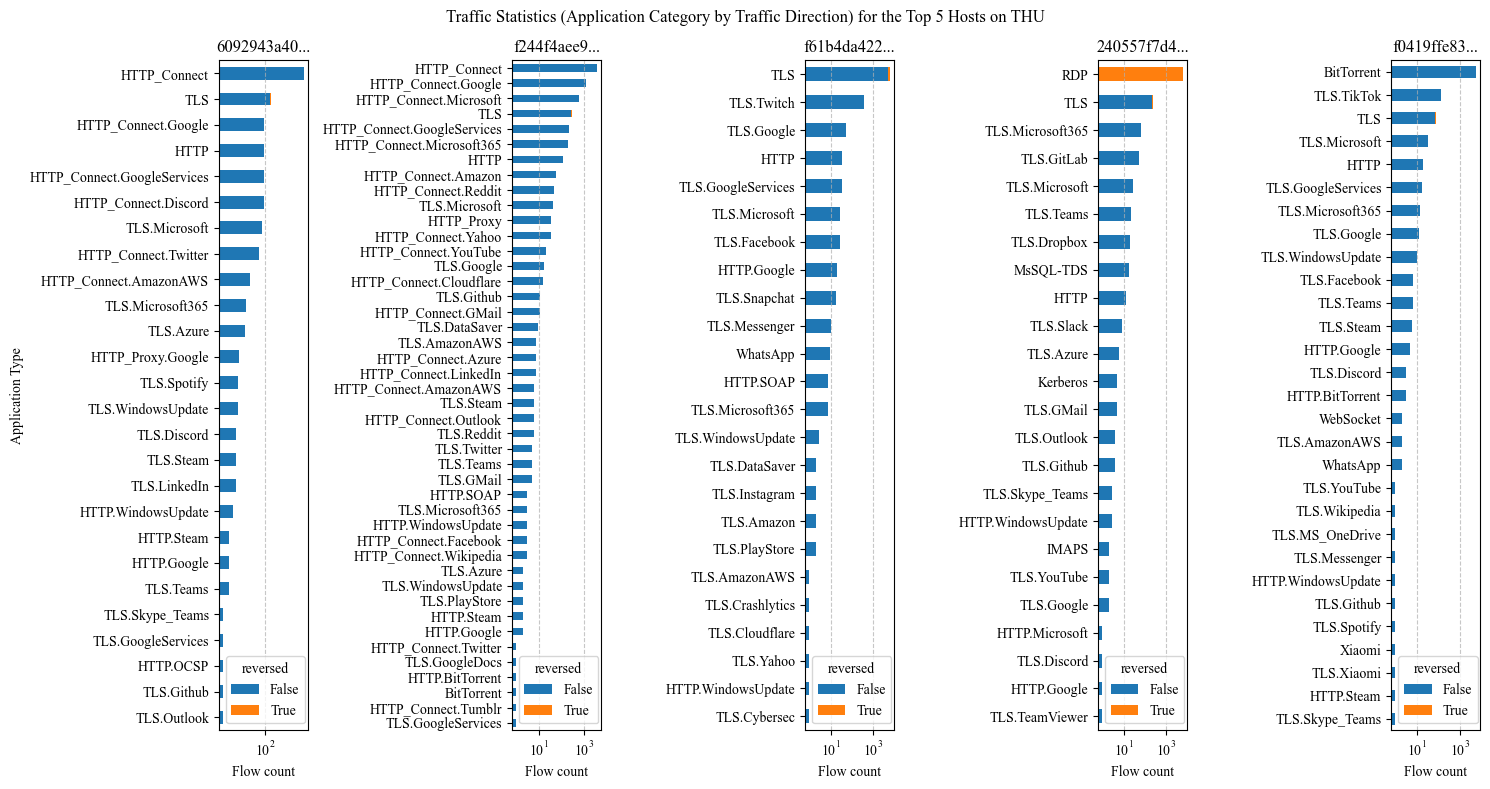

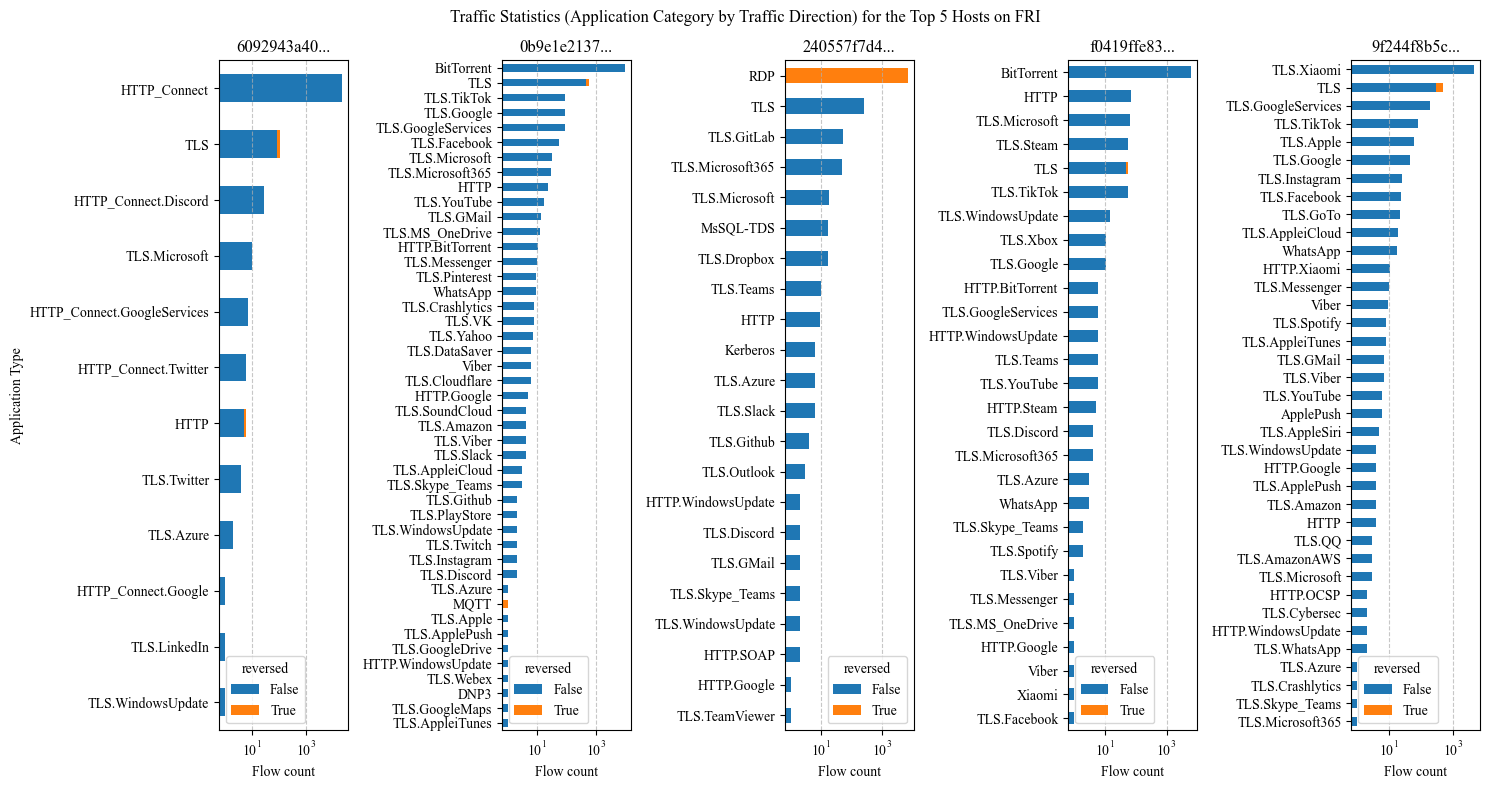

In [30]:
for day, df in zip(days, dfs):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 8))
    top_5_host = df['LAN_host'].value_counts().head(5).index
    
    for idx, a in enumerate(ax.flatten()):
        host = top_5_host[idx]
        count_df = df[df['LAN_host'] == host].groupby(['application_name', 'reversed']).size().unstack()
        count_df = count_df.reindex(df[df['LAN_host'] == host]['application_name'].value_counts(ascending=True).index)
        count_df.plot(kind='barh', stacked=True, ax=a)
        a.set_xlabel('Flow count')
        a.set_xscale('log')
        a.set_title(f"{host[:10]}...")
        a.set_ylabel('')
        a.grid(axis='x', linestyle='--', alpha=0.7)
    ax[0].set_ylabel('Application Type')
    fig.suptitle(f"Traffic Statistics (Application Category by Traffic Direction) for the Top 5 Hosts on {day}")
    plt.tight_layout()
    plt.savefig(f'plots/preprocessing/host_traffic_distributions/{day}.pdf')
    plt.show()

The figures show that the culprit for the high traffic amount on host `6092943a40...` was application *HTTP_Connect* resulting in unusually high amount of flows. The other leading applications are related to TLS, HTTP, BitTorrent or RDP. The nature of BitTorrent is to connect to various peers and download a small chunck of data from each of these instead of fetching the whole file from a single server. This behavior generates a substantially higher number of flows as each separate connection will have a unique 4-tuple and thus a separate flow record.

In terms of directionality apart from RDP only TLS and MQTT saw a substantial amount of reversed traffic (traffic originating at the outside of the local network). Host `240557f7d4...` saw many RDP connection flows from outside the network during the week (a few thousand from Tuesday to Friday). This may indicate an attack attempt against this specific service.

### Traffic Direction Distribution

In [31]:
for day, df in zip(days, dfs):
    print(day)
    print(df['reversed'].value_counts())
    print()

MON
reversed
False    1387667
True       76754
Name: count, dtype: int64

TUE
reversed
False    1033311
True       64645
Name: count, dtype: int64

WED
reversed
False    1305789
True       95178
Name: count, dtype: int64

THU
reversed
False    1023585
True       65727
Name: count, dtype: int64

FRI
reversed
False    865939
True      57275
Name: count, dtype: int64



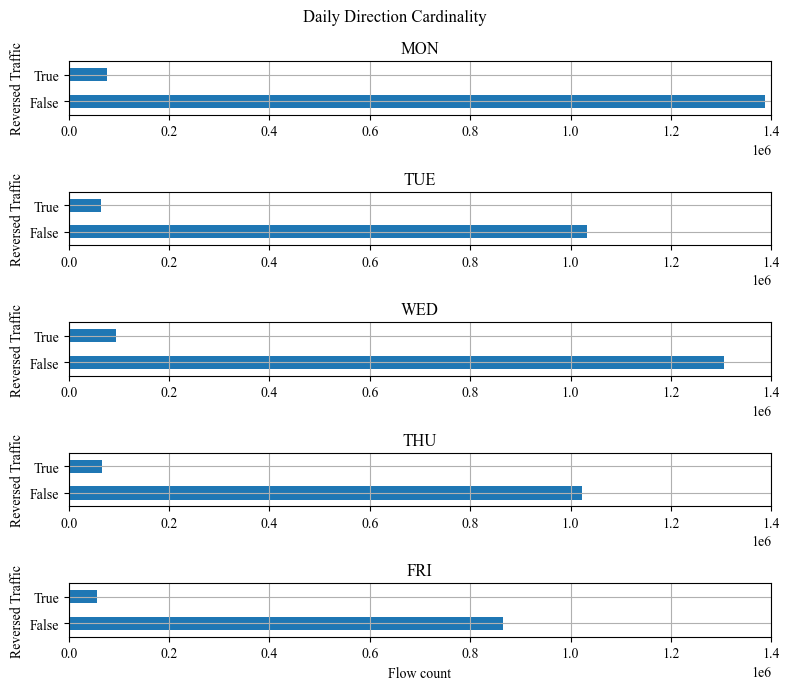

In [32]:
# Packet count ECDF-plot
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8, 7))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['reversed'].value_counts().plot(kind='barh', ax=a)
    a.set_title(days[idx])
    a.set_xlim(0, 1.4e6)
    a.set_ylabel('Reversed Traffic')
    a.grid(True)

ax[-1].set_xlabel('Flow count')
fig.tight_layout()
plt.savefig('plots/preprocessing/direction_cardinality.pdf')
fig.suptitle('Daily Direction Cardinality')
fig.tight_layout()
plt.show()

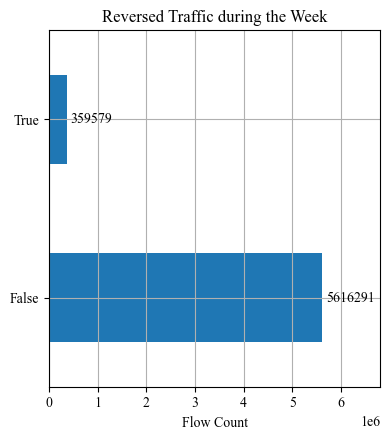

In [33]:
# Packet count ECDF-plot
plt.figure(figsize=(4, 4.5))
a = all_dfs['reversed'].value_counts().plot(kind='barh')
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
plt.xlim(0, 6.8e6)
plt.xlabel('Flow Count')
plt.ylabel('')
plt.grid()
plt.tight_layout()
plt.savefig('plots/preprocessing/direction_cardinality_all.pdf')
plt.title('Reversed Traffic during the Week')
plt.tight_layout()
plt.show()

When observing the directionality of traffic we see that the vast majority (one order of magnitude more) of flows were not reversed, i.e. their source is inside the observed LAN and they connect to servers on the WAN. Throughout the week the amount of reversed flows stayed the same while the non-reversed flows fluctuated. Let's investigate this further.

In [34]:
all_dfs = pd.concat(dfs)

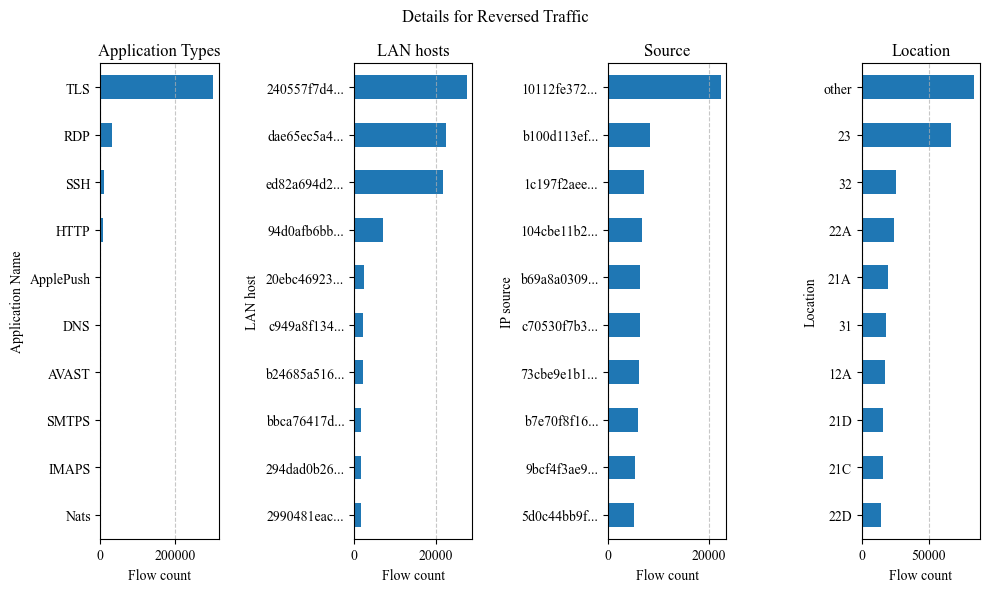

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

all_dfs[all_dfs['reversed']]['application_name'].value_counts(ascending=True)[-10:].plot(kind='barh', ax=ax[0])
ax[0].set_xlabel('Flow count')
ax[0].set_ylabel('Application Name')
ax[0].set_title('Application Types')
ax[0].grid(axis='x', linestyle='--', alpha=0.7)

all_dfs[all_dfs['reversed']]['LAN_host'].value_counts(ascending=True)[-10:].plot(kind='barh', ax=ax[1])
ax[1].set_xlabel('Flow count')
ax[1].set_ylabel('LAN host')
ax[1].set_title('LAN hosts')
ax[1].grid(axis='x', linestyle='--', alpha=0.7)
labels = [f'{s[:10]}...' for s in all_dfs[all_dfs['reversed']]['LAN_host'].value_counts(ascending=True)[-10:].index.to_list()]
ax[1].set_yticks(range(10), labels)

all_dfs[all_dfs['reversed']]['src_ip'].value_counts(ascending=True)[-10:].plot(kind='barh', ax=ax[2])
ax[2].set_xlabel('Flow count')
ax[2].set_ylabel('IP source')
ax[2].set_title('Source')
ax[2].grid(axis='x', linestyle='--', alpha=0.7)
labels = [f'{s[:10]}...' for s in all_dfs[all_dfs['reversed']]['src_ip'].value_counts(ascending=True)[-10:].index.to_list()]
ax[2].set_yticks(range(10), labels)

all_dfs[all_dfs['reversed']]['location'].value_counts(ascending=True)[-10:].plot(kind='barh', ax=ax[3])
ax[3].set_xlabel('Flow count')
ax[3].set_ylabel('Location')
ax[3].set_title('Location')
ax[3].grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle('Details for Reversed Traffic')
plt.savefig('plots/preprocessing/details_for_reversed_traffic.pdf')
plt.tight_layout()
plt.show()

We see that the majority of the reversed flows were TLS traffic, the host that received the highest amount was the host receiving the RDP traffic we identified earlier. The outside source was overwhelmingly from a single host.
RDP directed towards two specific hosts on the LAN network with one outstanding foreign address. In terms of location the majority of the reversed traffic was towards non-characterized locations (these may be servers on the local network not belonging to a specific dormitory building). The next location receiving more than 50000 reversed origin flows was Building 3 at Location 2.

<hr style="border-top: 1px dashed red;" />

#### <font color='red'>Potential Attack Analysis</font>

**Looking at the highest cardinality WAN address**

In [36]:
highest_WAN_src = all_dfs[all_dfs['reversed']]['src_ip'].value_counts().index[0]
highest_WAN_src

'10112fe37278fb150ca2ed1829e74be1baed4b79b55064a046c7be1b62f362b01524b645b693c307cd06a7f041e9bbd50bf703b188117cd39d9b8882a5abdd7c'

In [37]:
all_dfs[all_dfs['src_ip'] == highest_WAN_src]['dst_ip'].value_counts()

dst_ip
dae65ec5a46f0e3ed3808c0fc2c6d8ca3eec37d1169db5774853359a9d8c084ccbf9847012764fee3f6ec3cb25502abc9298ae39a9d80dee310bde3be7f63381    22216
f765840471945d4a19e5701a9ca0dc140f141411571d803c1bcd8667bdaf3cc7e152c9b20b1fe22dc01a9c445c3fac0cdb278d92607be2dd43af1f57c295235e        1
Name: count, dtype: int64

In [38]:
all_dfs[all_dfs['src_ip'] == highest_WAN_src]['application_name'].value_counts()

application_name
TLS    22217
Name: count, dtype: int64

The outside address with the highest incoming reversed origin traffic only participated in TLS connections and to only two LAN hosts (and only `dae65ec5a4...` in particular).

*By identifying the original IP address of the source of this traffic we see that it is an IP address assigned to an American company (registered in the Seychelles) but the IP address is registered in Ukraine.*

In [39]:
all_dfs[all_dfs['src_ip'] == 'dae65ec5a46f0e3ed3808c0fc2c6d8ca3eec37d1169db5774853359a9d8c084ccbf98470\
12764fee3f6ec3cb25502abc9298ae39a9d80dee310bde3be7f63381']['application_name'].value_counts()

application_name
TLS                   90619
HTTP                    308
TLS.Microsoft           155
TLS.Amazon               60
TLS.Google               53
TLS.Spotify              46
TLS.Discord              33
TLS.Microsoft365         27
HTTP.Xbox                20
TLS.Viber                14
TLS.Instagram            12
TLS.GoogleServices       12
TLS.PlayStore             8
HTTP.WindowsUpdate        8
TLS.AmazonAWS             7
TLS.Skype_Teams           6
TLS.YouTube               6
TLS.VK                    5
TLS.LinkedIn              4
TLS.Cloudflare            3
TLS.Facebook              3
STUN                      2
Viber                     2
TLS.Yahoo                 2
HTTP.SOAP                 1
TLS.Wikipedia             1
HTTP.Instagram            1
HTTP.Google               1
TLS.Alibaba               1
TLS.Teams                 1
Name: count, dtype: int64

In [40]:
all_dfs[all_dfs['src_ip'] == 'dae65ec5a46f0e3ed3808c0fc2c6d8ca3eec37d1169db5774853359a9d8c084ccbf98470\
12764fee3f6ec3cb25502abc9298ae39a9d80dee310bde3be7f63381']['dst_ip'].value_counts()

dst_ip
10112fe37278fb150ca2ed1829e74be1baed4b79b55064a046c7be1b62f362b01524b645b693c307cd06a7f041e9bbd50bf703b188117cd39d9b8882a5abdd7c    89416
10eb50820985adee2af948054512350d245dcfa2019869658e2384bfecb4d5dd3d3b07eee0c0e2c91ca0b8bd329e7a9bc2e8f6e5a48fcd42d88819ffbbc940cd      197
c09dcdf144815cd9185f58d67bc1092c4552e6f4eb55a69c31ed28b6353ca41c4b6fcb2c5d632e1fb706f30ebcbb74cf1aa91e61b66b781015e01882eaf31d1a      105
6dd59dd43dc07e590a98ad0e96c79f13c4a0d96f3eccdea0df0aa09e4ebd0668652fbf1edb492a5812bdc63c3e4828022d01665549dc3c4247f6260c3dedb5b3       89
370e7d18f5b969e211b3be355f7f657cad5c56f3aa3fdf816a142fe14625c0bbe16a33a6cf791b69ce78a57272d917828fa755c38812fac6215f6c86ac61d759       46
                                                                                                                                    ...  
6baf446090792456837af8db120de54b51cf05225b71641cbbcedc368b730f82dd9df43ea7c1cedb6ab302fe96ca75e9387fa58757fc85e5c38531502196aec8        1
9344da24b497808e0b082f0686a

The highest connection partner of this LAN host when it acts as the source of the traffic is still the WAN originator we saw earlier.

In [41]:
all_dfs[all_dfs['src_ip'] == highest_WAN_src]['splt_ps'].value_counts()

splt_ps
[343, 818, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

There are many similar flows in terms of packet size structure which suggests that the flows contained the same type of or even the exact same information.

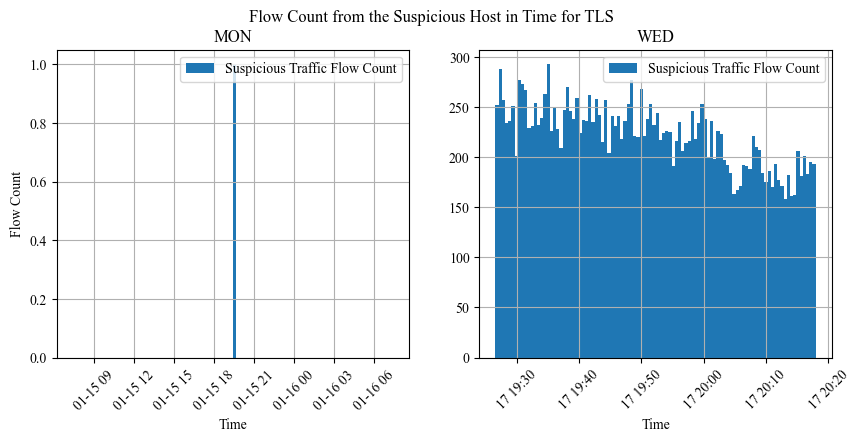

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

dfs_to_show = [dfs[0], dfs[2]]
days_to_show = [days[0], days[2]]
for idx, a in enumerate(ax.flatten()):
    df = dfs_to_show[idx]
    a.hist(df[df['src_ip'] == highest_WAN_src]['start_time_aggr'].to_list(), bins=100, label='Suspicious Traffic Flow Count')
    a.set_title(f'{days_to_show[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Time')
    if idx in [0, 3]:
        a.set_ylabel('Flow Count')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    a.legend()

fig.suptitle('Flow Count from the Suspicious Host in Time for TLS')
plt.savefig('plots/preprocessing/potential_attack_analysis/suspicious_flow_counts_tls.pdf')
plt.show()

There was exactly one flow on Monday (probably to that host with a single connection). The rest of the traffic occured on Wednesday. During Wednesday the flows were present throughout the whole measurement and with close to constant arrival rate.

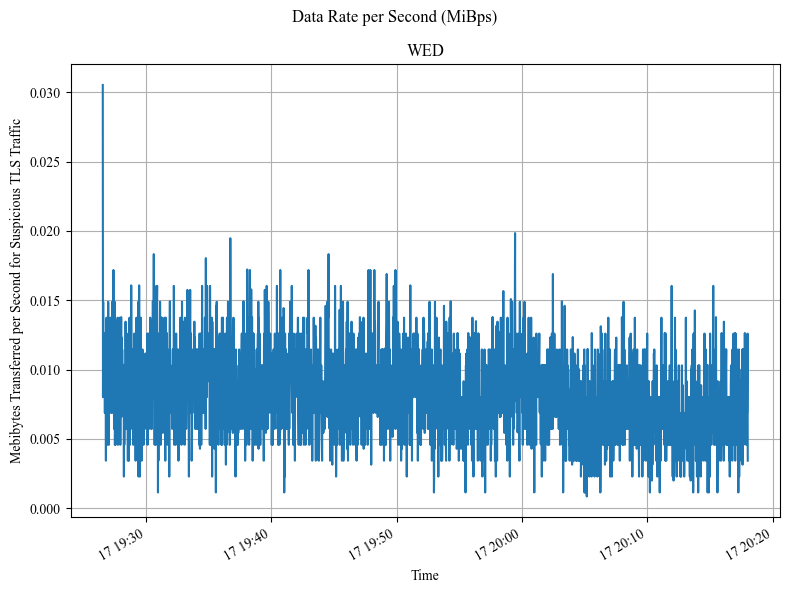

In [43]:
fig, a = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
df = dfs[2]
suspicious_data_rate_per_second = df[df['src_ip'] == highest_WAN_src].groupby('start_time_aggr')['bidirectional_bytes'].sum() / 1024 / 1024
# Plot the data rate
suspicious_data_rate_per_second.plot(kind='line', ax=a)
a.set_title('WED')
a.set_xlabel('Time')
a.set_ylabel('Mebibytes Transferred per Second for Suspicious TLS Traffic')
a.grid(True)

fig.suptitle('Data Rate per Second (MiBps)')
fig.tight_layout()
plt.savefig('plots/preprocessing/potential_attack_analysis/suspicious_data_rate_tls.pdf')
plt.show()

We see a highly uniform data rate on Wednesday as well.

**Looking at the highest cardinality LAN address**

In [44]:
highest_LAN_dst = all_dfs[all_dfs['reversed']]['LAN_host'].value_counts().index[0]
highest_LAN_dst

'240557f7d42677f7979456220d73477971cf348f72a93e3e84e4eb497b6e19eaba973c5d731b823e1b347e13b078f1ba00e8172eeeca1da60bdec244424d6182'

In [45]:
all_dfs[all_dfs['dst_ip'] == highest_LAN_dst]['application_name'].value_counts()

application_name
RDP          27358
TLS             76
MsSQL-TDS        2
Name: count, dtype: int64

In [46]:
all_dfs[all_dfs['dst_ip'] == highest_LAN_dst]['src_ip'].value_counts()

src_ip
5f39ee504a2050126aed6568b6c5c084bcf91e90ae726c0cfbe8d7fc4d45d3e7efe90e36e7c1f9139ae34592a985c0aa501b16902353f830e65cc7ff1b6f8541    2286
a33f1ec430afa7a739856bd75fe6e550154fc5e8e8dbca33cbbfac75a9ba338f647ae518b00313a8f72158411bc80b7e83ec8ba1d316b031b1eae77cc0748b3a    2225
9b7dd50883e74a4b2d683dcb1cecac5b3d977c950acc2dd9b2d061f6272479b07a8bc00b0fa94f9557e9791142a0dbfdf11c6f74299b0d08b432a3d3db974cee    2038
9dbef5848c1e38951b6bf6bcffc807fbe560ba7c25657b67dcbbd4f8f8f3b4a9de49038cf9c3b4f66505db55da387cece7395943fecefe3633b872d044864494    1952
5e81846ab886c3732e265755b34ba19ef567cd1b411e36890a9a7bf57ff81b6e0bb1e23ce118011e4a6c13943bcb8d000e8a5fc6e50465948b06a88cb0c3795f    1826
                                                                                                                                    ... 
01a1ed34f3fb4d51899f46fbe51932f00d6978ea0caa8823205c58eae4f5ca2a2480d54db8ec8ccde0496cccff87c24aa144ce3f00246c6dad54ab0af4fd3d3a       1
e5bfcb37feeeb1402a119901b3d793e911

In [47]:
# Top 20 origins
all_dfs[all_dfs['dst_ip'] == highest_LAN_dst]['src_ip'].value_counts()[:20]

src_ip
5f39ee504a2050126aed6568b6c5c084bcf91e90ae726c0cfbe8d7fc4d45d3e7efe90e36e7c1f9139ae34592a985c0aa501b16902353f830e65cc7ff1b6f8541    2286
a33f1ec430afa7a739856bd75fe6e550154fc5e8e8dbca33cbbfac75a9ba338f647ae518b00313a8f72158411bc80b7e83ec8ba1d316b031b1eae77cc0748b3a    2225
9b7dd50883e74a4b2d683dcb1cecac5b3d977c950acc2dd9b2d061f6272479b07a8bc00b0fa94f9557e9791142a0dbfdf11c6f74299b0d08b432a3d3db974cee    2038
9dbef5848c1e38951b6bf6bcffc807fbe560ba7c25657b67dcbbd4f8f8f3b4a9de49038cf9c3b4f66505db55da387cece7395943fecefe3633b872d044864494    1952
5e81846ab886c3732e265755b34ba19ef567cd1b411e36890a9a7bf57ff81b6e0bb1e23ce118011e4a6c13943bcb8d000e8a5fc6e50465948b06a88cb0c3795f    1826
9907cd2dd49dedbb3b57f6398ce472636f7e499fb4478a81a43f3349b9f42cfbc082224e6f13f8754def507aa1deea4e71e4f63d654c83beddf0621a37341e8f    1670
39d85784800f0a48127a14f81cc8b9ae409cd70871d3b766d12ae916771030095d747e7fd05ad20b5bd7850210c56adede4ab7dc7382a3bd8090c52e2d94edeb    1397
2018cf27f42f6924828aa9d01f41673998

Examining the original IP addresses we see that almost half of the connection attempts (9 out of 20) come from the same subnet. This may mean that from this subnet many clients connect but this may be an attack scenario trying to access the server on which the RDP port is open. The connection may be distributed among different originating hosts to elude firewall action against them.

*When examining the original non-anonymized subnet we see that it belongs to a Hong Kong company (registered in the UAE), however the IP addresses are Russian.*

In [48]:
all_dfs[(all_dfs['dst_ip'] == highest_LAN_dst) & (all_dfs['application_name'] == 'RDP')]['splt_ps'].value_counts()[:5]

splt_ps
[52, 52, 40, 87, 59, 201, 1186, 133, 91, 126, 270, 726, 40, 71, 106, 78, 40, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

By examining the Top5 packet size sequences we see that there were many flows that saw the exact same packet size patterns and there were only slight alterations among the different kinds. This further suggests that these were conncetion attempts to the RDP port.

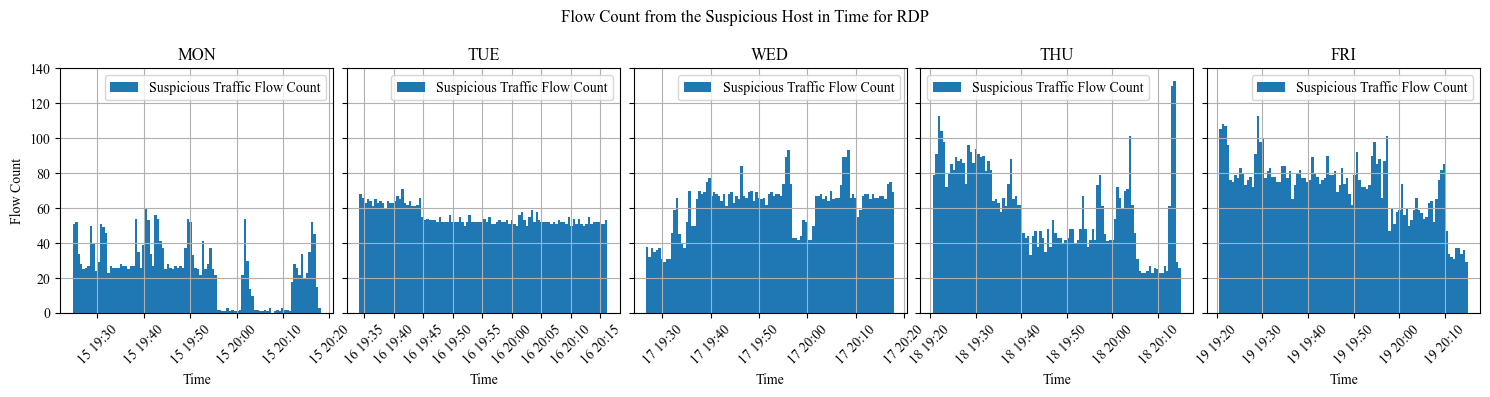

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    a.hist(df[(df['dst_ip'] == highest_LAN_dst) & (df['application_name'] == 'RDP')]['start_time_aggr'].to_list(), bins=100, label='Suspicious Traffic Flow Count')
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_ylim(0, 140)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Flow Count')
    a.grid(True)
    a.legend()
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/potential_attack_analysis/suspicious_flow_counts_rdp.pdf')
fig.suptitle('Flow Count from the Suspicious Host in Time for RDP')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

By examining the Flow Arrival Rate we see that on Monday there were two gaps that did no see such a high flow arrival rate while there are noticable spikes in flow arrival suggesting that the potential attack may have been carried out in bursts. However, data from other days, especially Tuesday does not back this up.

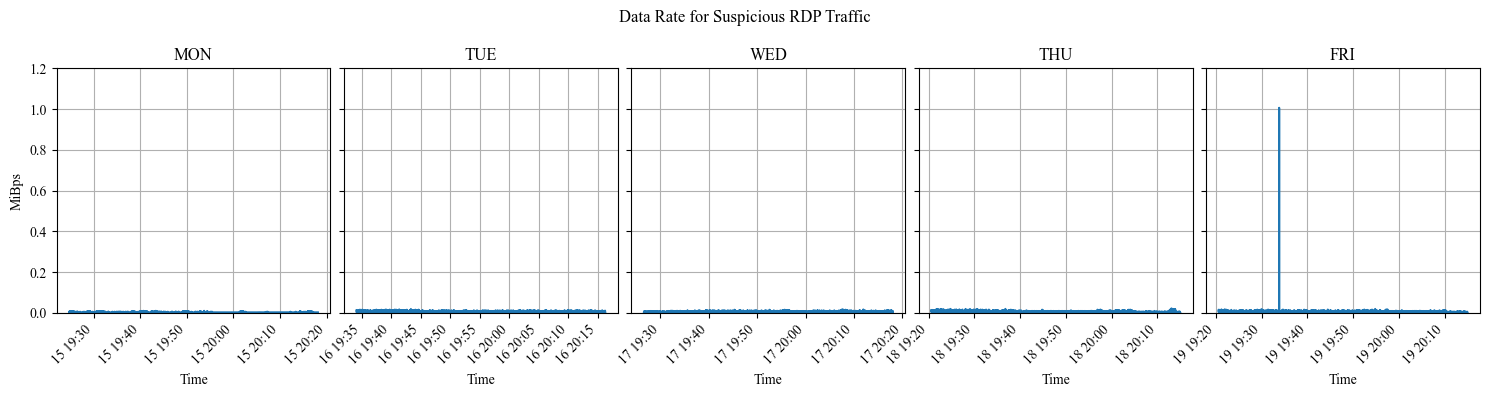

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    suspicious_data_rate_per_second = df[(df['dst_ip'] == highest_LAN_dst) & (df['application_name'] == 'RDP')].groupby('start_time_aggr')['bidirectional_bytes'].sum() / 1024 / 1024
    # Plot the data rate
    suspicious_data_rate_per_second.plot(kind='line', ax=a)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_ylim(0, 1.2)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('MiBps')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/potential_attack_analysis/suspicious_data_rate_rdp.pdf')
fig.suptitle('Data Rate for Suspicious RDP Traffic')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The data rate seems to follow similar patterns as the flow arrival with dips when lower flow arrival rate was seen and spikes at higher flow arrival count. The exception to this is the traffic on Friday. On this day the the base data rate is around the same as on other days, however at one time the data rate jumps multiple orders of magnitude higher. This point in time may indicate a genuine connection when in one flow a higher amount of data was transmitted, instead of small connection attemps across many flows.

**Examining the high-data-rate connection on Friday**

In [51]:
dffr = dfs[-1]
max(dffr[(dffr['dst_ip'] == highest_LAN_dst) & (dffr['application_name'] == 'RDP')]['bidirectional_bytes'])

1048463

In [52]:
dffr[(dffr['dst_ip'] == highest_LAN_dst) & (dffr['application_name'] == 'RDP') & (dffr['bidirectional_bytes'] == 1048463)]

id  expiration_id  \
557530  452194             -1   

                                                   src_ip  \
557530  dcdb5ff24aa9a3116ad4b9f8b2853822538a3afecb7d21...   

                                                   dst_ip  protocol  \
557530  240557f7d42677f7979456220d73477971cf348f72a93e...         6   

        ip_version  vlan_id  bidirectional_first_seen_ms  \
557530           4        0                1705692828965   

        bidirectional_last_seen_ms  bidirectional_duration_ms  ...  \
557530               1705692839528                      10563  ...   

        application_category_name  application_confidence  location  \
557530               RemoteAccess                       6     other   

        connection_type reversed start_second     start_time_aggr  \
557530          unknown     True   1705692828 2024-01-19 19:33:48   

       LAN2WAN_bytes WAN2LAN_bytes  \
557530       1008733         39730   

                                                 LAN_host  
557530  240557f7d42677f7979456220d73477971cf348f72a93e...  

[1 rows x 28 columns]

The start time was at 2024-01-19 19:33:48 which lines up with the spike on the data-rate plot.

In [53]:
dffr[(dffr['dst_ip'] == highest_LAN_dst) & (dffr['application_name'] == 'RDP') & (dffr['bidirectional_bytes'] == 1048463)]['splt_ps'].to_list()

['[60, 60, 52, 90, 71, 52, 156, 1196, 52, 153, 111, 52, 537, 201, 105, 89, 52, 89, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 409, 1240, 1240, 1240, 1240, 489, 52, 52, 1240, 1093, 52, 137, 169, 121, 553, 52, 52, 521, 121, 121, 121, 190, 121, 52, 52, 137, 121, 52, 121, 361, 745, 1240, 1240, 1240, 765, 89, 89, 52, 89, 89, 89, 52, 89, 137, 52, 121, 52, 52, 52, 52, 601, 52, 52, 52, 52, 52, 1240, 1240, 1240, 1240, 1240, 1240, 273, 52, 52, 121, 153, 52, 185, 121, 441, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 445, 1240, 1240, 52, 1240, 52, 52, 52, 1229, 185, 121, 52, 52, 52, 52, 137, 52, 137, 137, 52, 137, 137, 52, 137, 137, 52, 137, 137, 52, 137, 137, 52, 89, 89, 1240, 1240, 1240, 253, 647, 137, 52, 89, 985, 89, 137, 137, 52, 137, 1240, 1240, 1240, 1240, 1209, 137, 137, 52, 137, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 1240, 137, 1240, 1240, 1240, 1240, 857, 89, 89, 137, 89, 137, 52, 52, 1240, 1240, 1240, 1240, 1240, 1240, 12

Examining this one specific connection backs up that indeed this was a genuine long flow with many packets transmitted.

<hr style="border-top: dotted 1px; background-color: transparent;" />

*Consulting with the network administrator of the measured network and the owner of the corresponding hosts, they were able to confirm that indeed they saw connection attempts to the open RDP ports during this time. This could be considered as part of the background noise of the Internet.*

<hr style="border-top: 1px dashed red;" />

### Location Distribution

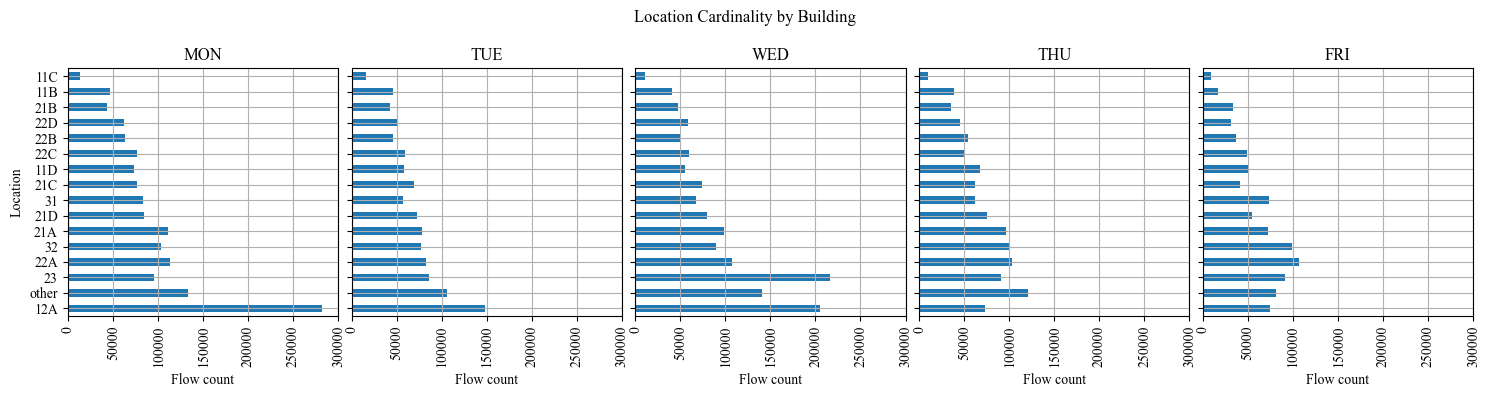

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
order = all_dfs['location'].value_counts().index

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['location'].value_counts()[order].plot(kind='barh', ax=a)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow count')
    a.set_xlim(0, 300_000)
    if idx == 0:
        a.set_ylabel('Location')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=90)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/location_cardinality_lowlevel_daily.pdf')
fig.suptitle('Location Cardinality by Building')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

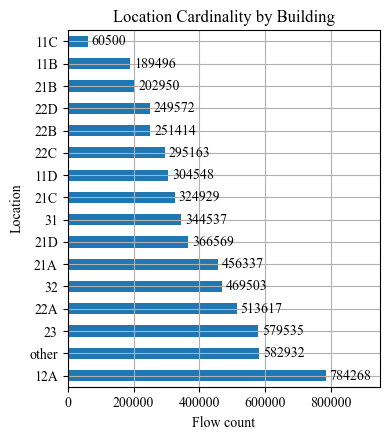

In [55]:
fig, a = plt.subplots(nrows=1, ncols=1, figsize=(4, 4.5))

all_dfs['location'].value_counts().plot(kind='barh', ax=a)
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
a.set_xlabel('')
a.set_ylabel('') 
a.set_xlabel('Flow count')
a.set_ylabel('Location')
a.set_xlim(0, 950_000)
a.grid(True)
fig.tight_layout()
plt.savefig('plots/preprocessing/location_cardinality_lowlevel.pdf')
a.set_title('Location Cardinality by Building')
fig.tight_layout()
plt.show()

We see that the location with the highest cardinality tends to fluctuate day-by-day, however Location 12A, 22A and 23 and 32 seem to have a high amount of traffic throughout the week. The amount of locationally non-assigned traffic is also substantial. Building 11C sees the least traffic every day with only a few thousand flows.

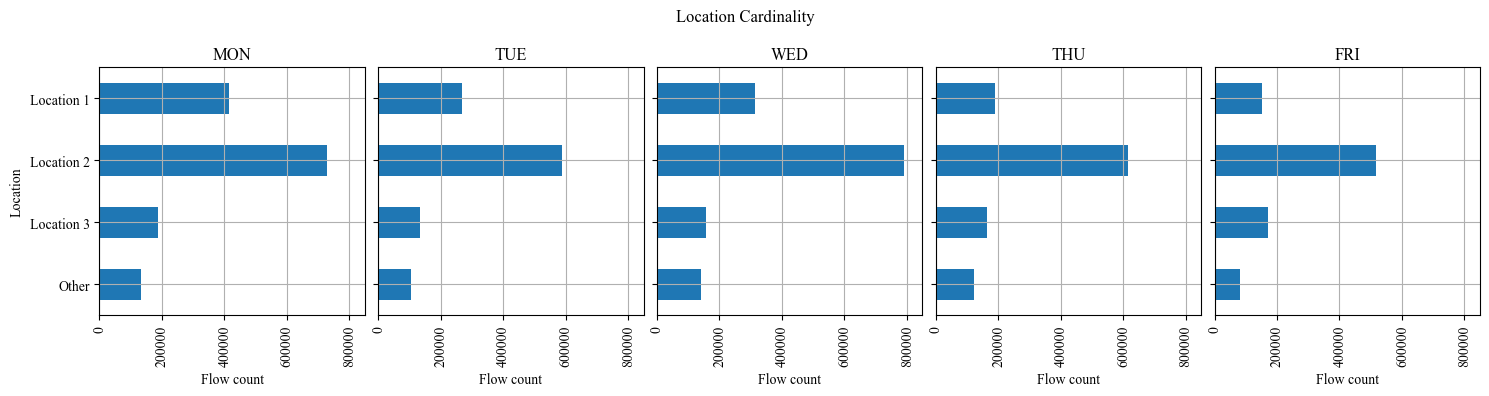

In [56]:
location_assignment = {'1': 'Location 1', '2': 'Location 2', '3': 'Location 3', 'o': 'Other', 'u': 'unassigned'}
order = list(location_assignment.values())[:-1]
order.reverse()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['location'].apply(lambda loc: location_assignment[loc[0]]).value_counts()[order].plot(kind='barh', ax=a)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlim(0, 850_000)
    a.set_xlabel('Flow count')
    if idx == 0:
        a.set_ylabel('Location')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=90)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/location_cardinality_highlevel_daily.pdf')
fig.suptitle('Location Cardinality')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

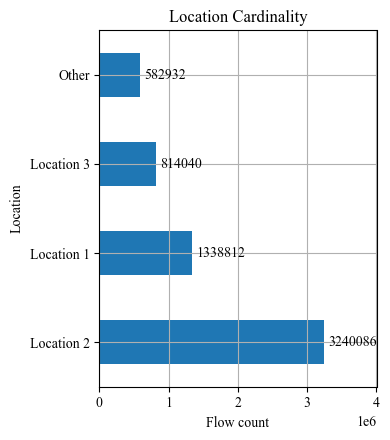

In [57]:
fig, a = plt.subplots(nrows=1, ncols=1, figsize=(4, 4.5))
all_dfs['location'].apply(lambda loc: location_assignment[loc[0]]).value_counts().plot(kind='barh', ax=a)
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
a.set_xlabel('')
a.set_ylabel('') 
a.set_xlabel('Flow count')
a.set_ylabel('Location')
a.set_xlim(0, 4e6)
a.grid(True)
fig.tight_layout()
plt.savefig('plots/preprocessing/location_cardinality_highlevel.pdf')
a.set_title('Location Cardinality')
fig.tight_layout()
plt.show()

When we group by Location we see that by far the highest amount of flows were generated at *Location 2* during the week (more than 500,000 flows every day). This location has the highest amount of buildings and accommodated students, therefore this is to be expected. On Monday *Location 1* also had a substantial share with more than 400,000 flows, however still *Location 2* almost doubled its flow count. In the overall count throughout the week the traffic st *Location 2* exceeds the traffic captured from other locations combined.

(Knowing this statistic, the rest of our analysis will focus mainly on *Location 2*.)

### Connection Type Distribution

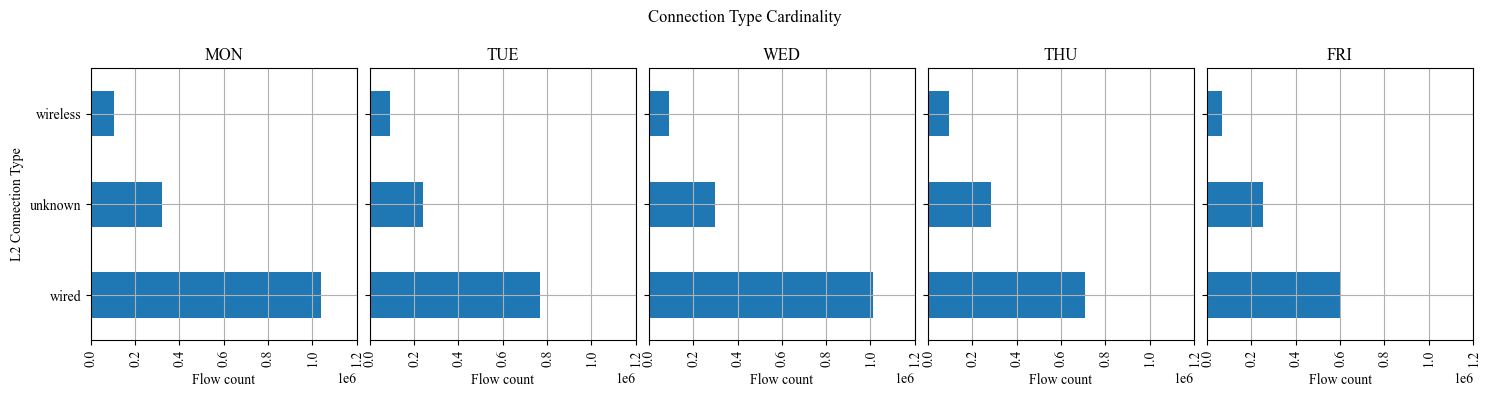

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
order = all_dfs['connection_type'].value_counts().index

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['connection_type'].value_counts()[order].plot(kind='barh', ax=a)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow count')
    a.set_xlim(0, 1_200_000)
    if idx == 0:
        a.set_ylabel('L2 Connection Type')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=90)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/connection_type_cardinality.pdf')
fig.suptitle('Connection Type Cardinality')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

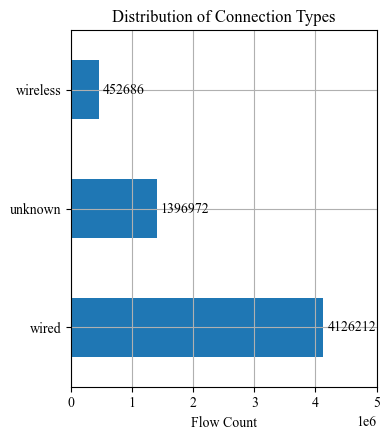

In [59]:
plt.figure(figsize=(4, 4.5))
a = all_dfs['connection_type'].value_counts().plot(kind='barh')
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
plt.xlabel('Flow Count')
plt.ylabel('')
plt.grid()
plt.xlim(0, 5e6)
plt.tight_layout()
plt.savefig('plots/preprocessing/connection_type_cardinality_all.pdf')
plt.title('Distribution of Connection Types')
plt.tight_layout()
plt.show()

The vast majority of the measured traffic comes from wired hosts.

### Application types

The dataset contains two columns regarding application type. The `application_category_name` represent aggregate categories. We first investigate this grouping.

In [60]:
for day, df in zip(days, dfs):
    print(day)
    print(df['application_category_name'].value_counts())
    print()

MON
application_category_name
Web               889414
SocialNetwork     126057
Cloud             103184
Download           59807
Network            50800
Collaborative      41764
Advertisement      34473
Media              23309
Game               21096
Chat               20200
Music              13350
SoftwareUpdate     12323
Video              10821
Cybersecurity      10783
Streaming           8390
System              7708
Email               7100
RemoteAccess        6614
ConnCheck           6598
VoIP                6326
VPN                 1577
DataTransfer         917
VirtAssistant        915
Database             338
RPC                  333
Mining               195
Shopping              17
IoT-Scada             12
Name: count, dtype: int64

TUE
application_category_name
Web               626900
SocialNetwork     103186
Cloud              82381
Download           59942
Network            38593
Collaborative      34707
Advertisement      24645
Chat               17962
Game         

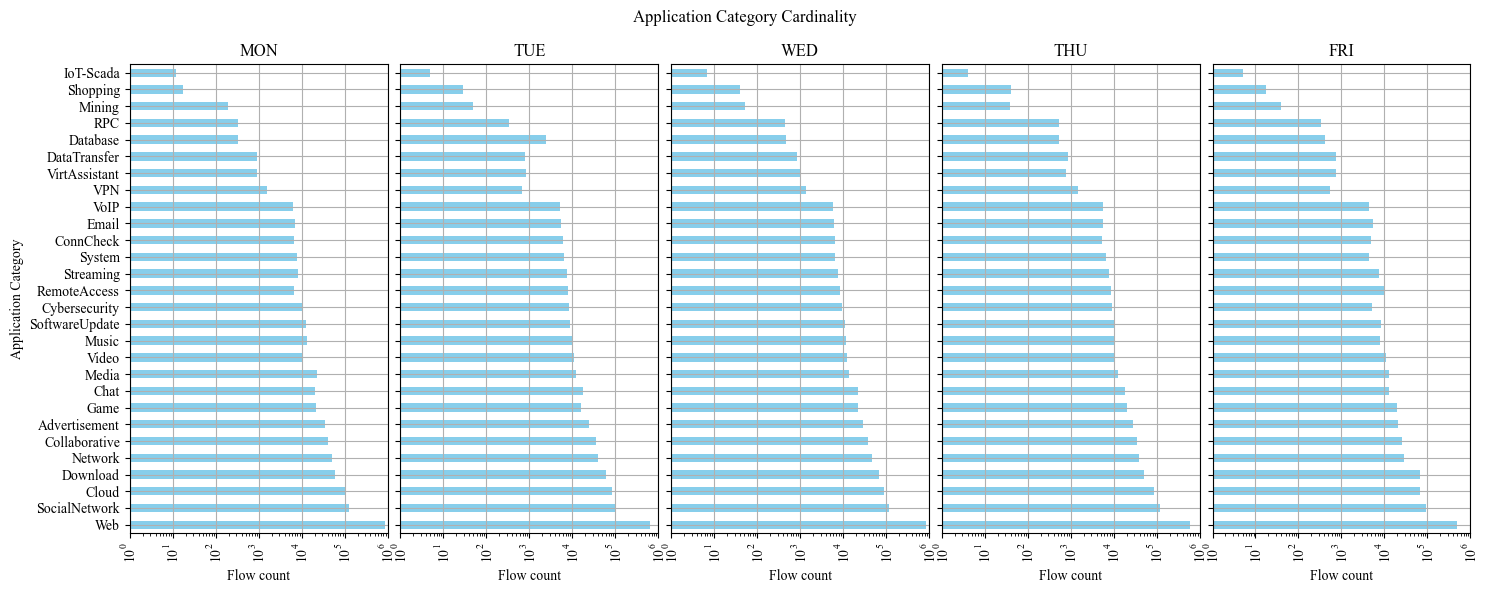

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
order = all_dfs['application_category_name'].value_counts().index

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['application_category_name'].value_counts()[order].plot(kind='barh', color='skyblue', ax=a, logx=True)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow count')
    a.set_xlim(1, 1_000_000)
    if idx == 0:
        a.set_ylabel('Application Category')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=90)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/application_category_cardinality.pdf')
fig.suptitle('Application Category Cardinality')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

We observe the following:

1. Some categories, such as *Web*, have a high number of data points (over 500,000 every day and reaching 800,000 on to occasions).
2. Other categories, such as *IoT-Scada*, *Shopping*, and *Mining*, have very few data points (fewer than 50).
3. The rest of the categories have varying cardinalities ranging from a few thousand to tens of thousands of data points.

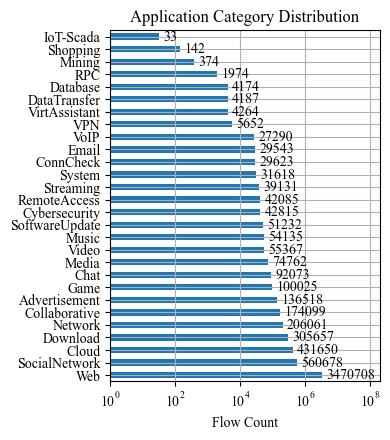

In [62]:
plt.figure(figsize=(4, 4.5))
a= all_dfs['application_category_name'].value_counts().plot(kind='barh')
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
plt.xlabel('Flow Count')
plt.ylabel('')
plt.grid()
plt.xscale('log')
plt.xlim(1, 2e8)
plt.tight_layout()
plt.savefig('plots/preprocessing/application_category_cardinality_all.pdf')
plt.title('Application Category Distribution')
plt.tight_layout()
plt.show()

In [63]:
for day, df in zip(days, dfs):
    print(day)
    application_name_counts = df['application_name'].value_counts()
    print(application_name_counts.head(20))
    print()

MON
application_name
TLS                   496790
HTTP_Connect          201119
TLS.Microsoft         107857
TLS.TikTok             67820
TLS.Google             54752
BitTorrent             46896
HTTP                   44679
TLS.GoogleServices     41751
TLS.Facebook           35078
TLS.Apple              29396
TLS.Microsoft365       25696
TLS.AppleiCloud        22901
DNS                    18948
TLS.YouTube            13588
TLS.Spotify            11723
TLS.Instagram          11375
DNS.Google             10819
TLS.Steam              10450
TLS.WindowsUpdate      10207
HTTP.YouTube            9350
Name: count, dtype: int64

TUE
application_name
TLS                   378221
HTTP_Connect           91037
TLS.Microsoft          86846
TLS.TikTok             55972
BitTorrent             51573
TLS.Google             43637
HTTP                   34622
TLS.GoogleServices     31994
TLS.Facebook           29168
TLS.Apple              26659
TLS.Microsoft365       22303
TLS.AppleiCloud        19842
DNS

The `application_name` provides a more granular view with the exact application marked. Different flows may be categorized into distinct categorizes based on whether they carried TLS specific information, used the QUIC protocol or HTTP protocol or performed different services inside the specific application. TLS leeds as the most popolous application used in the measured traffic.

In [64]:
application_name_counts[application_name_counts.index.str.contains('Facebook')]

application_name
TLS.Facebook             18901
HTTP_Connect.Facebook      779
DNS.Facebook               159
STUN.FacebookVoip          107
HTTP.Facebook               18
Name: count, dtype: int64

This approach divides the flows into many application groups with smaller overall cardinality. This poses challanges for data analysis. For instance TLS appears as a standalone category as well as subcategories of different applications. Another example is that traffic observed for social media application Facebook appears under 5 separate categories: TLS, 2 types of HTTP, STUN and DNS traffic.

These questions require in-depth analysis, examining different flow types behaviors for the same application and the same flow types for different applications. These questions do not form part of our current study and remain open for potential future work.

### Expiration ID

In [65]:
for day, df in zip(days, dfs):
    print(day)
    print(df['expiration_id'].value_counts())
    print()

MON
expiration_id
-1    1229776
 0     224401
 1      10244
Name: count, dtype: int64

TUE
expiration_id
-1    906109
 0    182760
 1      9087
Name: count, dtype: int64

WED
expiration_id
-1    1163458
 0     227923
 1       9586
Name: count, dtype: int64

THU
expiration_id
-1    892046
 0    188110
 1      9156
Name: count, dtype: int64

FRI
expiration_id
-1    762623
 0    153487
 1      7104
Name: count, dtype: int64



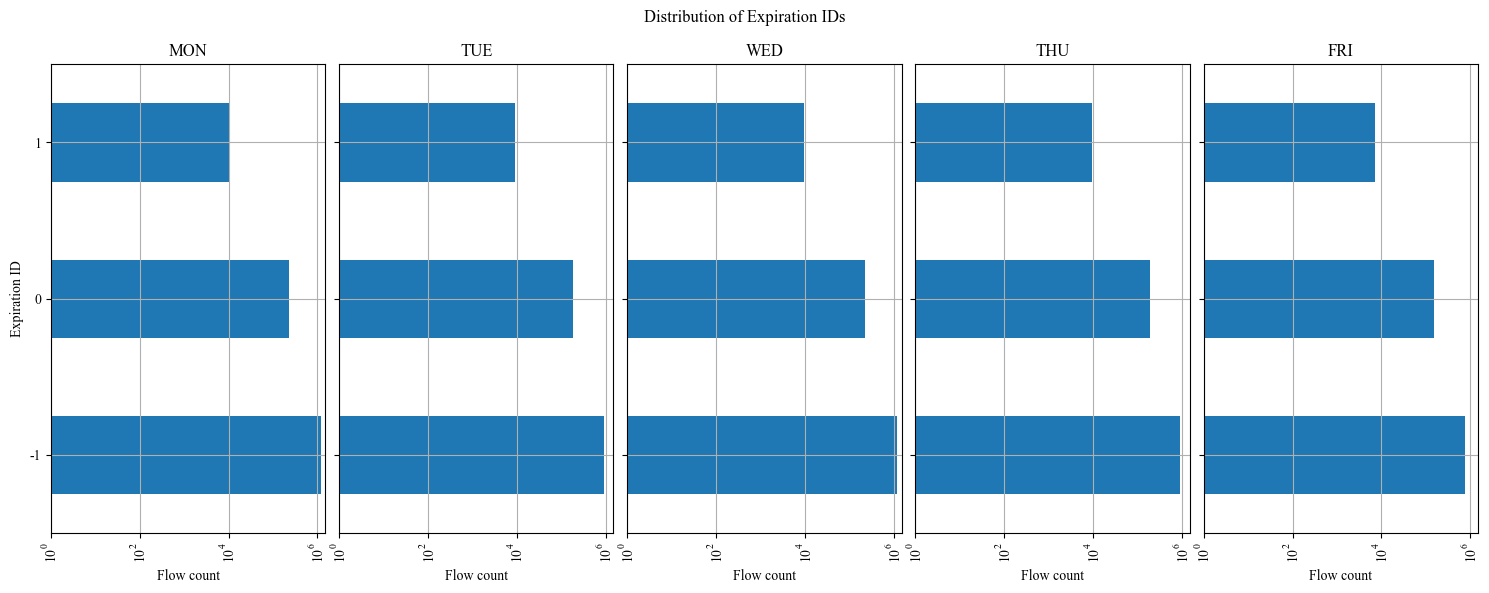

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
order = all_dfs['expiration_id'].value_counts().index

for idx, a in enumerate(ax.flatten()):
    df = dfs[idx]
    df['expiration_id'].value_counts()[order].plot(kind='barh', ax=a, logx=True)
    a.set_title(f'{days[idx]}')
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_xlabel('Flow count')
    a.set_xlim(1, 1_500_000)
    if idx == 0:
        a.set_ylabel('Expiration ID')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=90)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/expiration_id_distribution.pdf')
fig.suptitle('Distribution of Expiration IDs')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

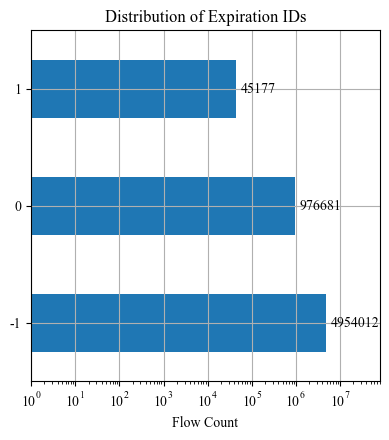

In [67]:
plt.figure(figsize=(4, 4.5))
a = all_dfs['expiration_id'].value_counts().plot(kind='barh')
for p in a.patches:  # ax.patches contains the list of bars
    if p.get_width() != 0:
        a.annotate(str(p.get_width()),  # Use the bar's width (value) as label
                    (p.get_width(), p.get_y() + p.get_height() / 2),  # Position at the end of the bar
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords='offset points',  # Offset (5, 0) from the end of the bar
                    va='center',  # Center the label vertically with respect to the bar
                    ha='left')    # Align the text to the left
plt.xlabel('Flow Count')
plt.ylabel('')
plt.grid()
plt.xscale('log')
plt.xlim(1, 8e7)
plt.tight_layout()
plt.savefig('plots/preprocessing/expiration_id_distribution_all.pdf')
plt.title('Distribution of Expiration IDs')
plt.tight_layout()
plt.show()

The vast majority of the flows were expired by *natural TCP expiration* (i.e. the FIN-ACK 3-way handshake of the TCP connection termination) indicated by `-1` using the custom NFPlugin. About a 200,000 flows every day were also ended by *idle timeout*, i.e. no further packet was received after an idle time of 2 minutes. *Active timeout* was only only triggered in the case of a few thousand flows every day.

The `expiration_id` value only becomes available once a flow is exported from into the flow cache after termination. Our research aims to study the flows when they are still in the live traffic state therefore this feature will not be considered for our study.

### VLAN characteristics

In [68]:
for day, df in zip(days, dfs):
    print(day)
    print(df['vlan_id'].value_counts())
    print()

MON
vlan_id
0    1464421
Name: count, dtype: int64

TUE
vlan_id
0    1097956
Name: count, dtype: int64

WED
vlan_id
0    1400967
Name: count, dtype: int64

THU
vlan_id
0    1089312
Name: count, dtype: int64

FRI
vlan_id
0    923214
Name: count, dtype: int64



All traffic belongs to *vlan0*.

# Vertical Separation of Flows: Identifying LAN delays

One of the metrics recorded by NFStream in the early stages of the flow (SPLT analysis) is the Packet Inter-Arrival Time (PIAT), represented by the `splt_piat_ms` feature. This records the time elapsed between two packets of the same flow arriving at the observation point in milliseconds. We assume delay introduced by the local endpoints to be negligible in comparison to latency due to network circumstances (hence we focus only on TCP traffic as outlined earlier).

The packets may arrive from either the WAN segment of the network, or the LAN where the flow measurement is performed. This directionality is recorded in the `splt_direction` column (**0**: source to destination (LAN to WAN *assuming that the initiator of the network communication is a host on the LAN side*), **1**: destination to source (WAN to LAN), **-1**: the flow had no packet at this index). 

Traffic may arrive as a burst of multiple packets. Therefore we only consider the time between receiving the last packet of a burst in the incoming direction ($splt\_direction=1$) and the first outgoing packet ($splt\_direction=0$) that is a response to the aforementioned traffic in the same flow. This also accounts for the Cumultative Acknowledgement mechanism in TCP in which the current receiving side (i.e. in this case the LAN source) instead of acknowledging all packets one-by-one, acknowledges all bytes up to a specified sequence number encompassing the data of multiple packets. This is done in order to reduce the number of ACK packets and with them the possibility of congestion in the network. When using Cumulative Acknowledgement the LAN latency is only calculated between the last received packet that warrants a cumulative acknowledgement, and the generated ACK packet.

The following images illustrates the PIAT values extracted by the approach. Marked with a purple border are the resulting LAN delays.

![Vertical Separation](images/vertical-separation.svg) |
-
Vertical Separation of Flows

Another early flow feature is the packet size, recorded in `splt_ps`. Every two neighboring packets have a PIAT, i.e. every PIAT has one packet on either side. The size of these two neighboring packets may result useful in our analysis, therefore we also record the average size of these two.

The algorithm below (<span style="color: blue; font-family: Courier New;">delay_extraction</span>) performs these steps, returning the list of LAN delays, their corresponding timestamps and neighboring packet sizes.

The following function performs the vertical separation for a flow, producing the list of LAN delays and its corresponding attributes. The timestamps are referenced to the start of the flow which is represented by the `bidirectional_first_seen_ms` feature. 

In [69]:
def vertical_separation(row, **kwargs):
    # Defining imports and functions here for parallel processing
    from statistics import mean
    import pandas as pd
    
    def identify_LAN_delay(dir, prev_dir, reversed):
        if reversed:
            # dir: dst2src (LAN2WAN), prev_dir: src2dst (WAN2LAN)
            return dir == 1 and prev_dir == 0
        # dir: src2dst (LAN2WAN), prev_dir: dst2src (WAN2LAN)
        return dir == 0 and prev_dir == 1
    
    def delay_extraction(splt_dir, splt_piat, splt_ps, start_time, reversed):
        prev_dir = -1
        D = []
        nei_ps = []
        timestamps = []
        elapsed_time = 0
        for idx, dir in enumerate(splt_dir):
            if idx == 0:
                prev_dir = dir
            else:
                if identify_LAN_delay(dir, prev_dir, reversed):
                    D.append(splt_piat[idx])
                    nei_ps.append(mean([splt_ps[idx-1], splt_ps[idx]]))
                    timestamps.append(start_time + elapsed_time)
                elapsed_time += splt_piat[idx]
                prev_dir = dir
        return D, timestamps, nei_ps


    
    # Extracting the early flow statistical values
    splt_dir = [int(x) for x in row['splt_direction'][1:-1].split(',')]
    splt_piat = [int(x) for x in row['splt_piat_ms'][1:-1].split(',')]
    splt_ps = [int(x) for x in row['splt_ps'][1:-1].split(',')]
    # Extracting the delays, timestamps and neighboring packet sizes.
    D, timestamps, nei_ps = delay_extraction(splt_dir, splt_piat, splt_ps, row['bidirectional_first_seen_relative_ms'], row['reversed'])

    return pd.Series([D, timestamps, nei_ps])

To make analysis easier from this point we reset the flow start and end timestamps so that the first flow start at 0 ms.

In [70]:
for df in tqdm(dfs):
    start = df['bidirectional_first_seen_ms'].iloc[0]
    df['bidirectional_first_seen_relative_ms'] = df['bidirectional_first_seen_ms'] - start
    df['bidirectional_last_seen_relative_ms'] = df['bidirectional_last_seen_ms'] - start

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.91it/s]


In [71]:
for df in dfs:
    df[['LAN_delay', 'LAN_delay_timestamps', 'LAN_delay_neighboring_PS']] = df.parallel_apply(vertical_separation, axis=1)

In [72]:
dfs[3].head(1)

id  expiration_id                                             src_ip  \
2  1242184              1  04eb67bdab1e53c132d56798602d510b75c8307d82edbc...   

                                              dst_ip  protocol  ip_version  \
2  6cafb2ffe124e4299c223b759ddb213bc8982de462ce3b...         6           4   

   vlan_id  bidirectional_first_seen_ms  bidirectional_last_seen_ms  \
2        0                1705605636430               1705607435222   

   bidirectional_duration_ms  ...  start_second     start_time_aggr  \
2                    1798792  ...    1705605636 2024-01-18 19:20:36   

   LAN2WAN_bytes  WAN2LAN_bytes  \
2         187163         236384   

                                            LAN_host  \
2  04eb67bdab1e53c132d56798602d510b75c8307d82edbc...   

  bidirectional_first_seen_relative_ms bidirectional_last_seen_relative_ms  \
2                                    0                             1798792   

                                           LAN_delay  \
2  [47, 61, 50, 52, 53, 0, 53, 53, 48, 50, 55, 52...   

                                LAN_delay_timestamps  \
2  [123, 296, 3189, 4993, 5769, 6266, 9326, 12399...   

                            LAN_delay_neighboring_PS  
2  [96.5, 104.5, 96.5, 104.5, 104.5, 104.5, 96.5,...  

[1 rows x 33 columns]

It is useful to examine the length of the resulting LAN delay list, which are reduced PIAT list. Since we are going to use this for our analysis, for the same reason we dropped flows with less than two packets, we may drop flows with less than 2 LAN delays as well.

In [73]:
for day, df in zip(days, dfs):
    print(day)
    # Filtering rows where 'LAN delay' is an empty or one element list
    empty_lan_delay_df = df[df['LAN_delay'].apply(len) < 2]
    print(f'Number of flows with short LAN delay list: {len(empty_lan_delay_df)}')
    print()

MON
Number of flows with short LAN delay list: 107422

TUE
Number of flows with short LAN delay list: 85430

WED
Number of flows with short LAN delay list: 118015

THU
Number of flows with short LAN delay list: 86482

FRI
Number of flows with short LAN delay list: 77583



In [74]:
df_filtereds = []

for df in tqdm(dfs):
    df_filtered = df[df['LAN_delay'].apply(len) > 1].reset_index(drop=True)
    df_filtereds.append(df_filtered)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


---

After the filtering steps it may result fruitful to examine the data characteristics again. This time we only plot the CDF plots for the three studied features. We unite the data from the five days for easier viewing.

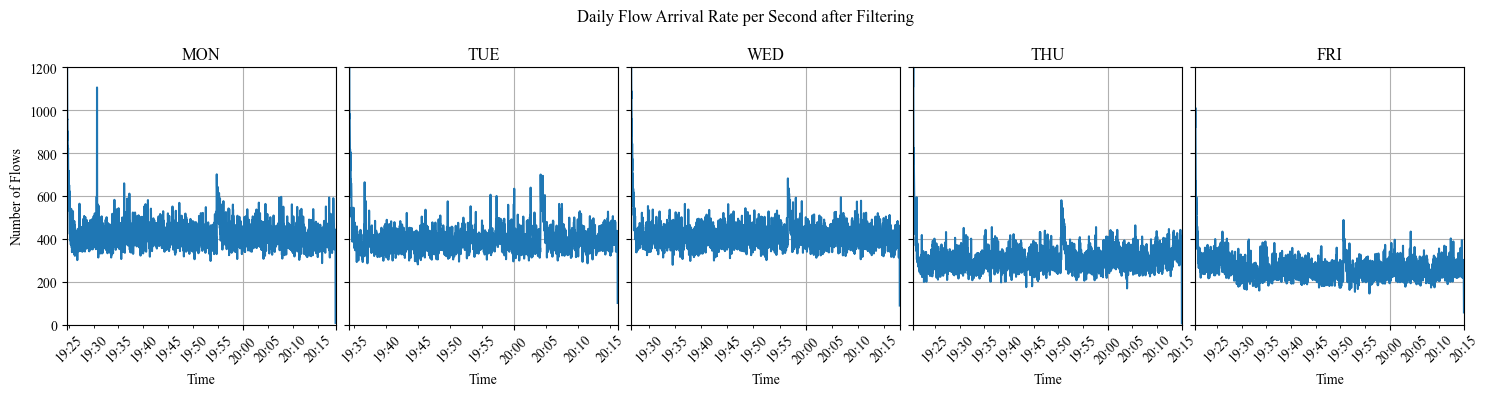

In [75]:
# after filtering count the number of flows starting each second
flow_counts = []
for df in df_filtereds:
    flow_counts.append(df['start_time_aggr'].value_counts().sort_index())

# Plot the flow arrival rate
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    flow_counts[idx].plot(kind='line', ax=a)
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('')   
    a.set_ylim(0, 1200)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Number of Flows')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])
        
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/flow_arr_rate_after_filtering.pdf')
fig.suptitle('Daily Flow Arrival Rate per Second after Filtering')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The flow arrival rates got considerably lower (to and average of 400 flows/s as opposed to around 1000 flows/s) and show a more consistent distribution over time. There are still some spikes of high arrival rate (leading with the one on Tuesday).

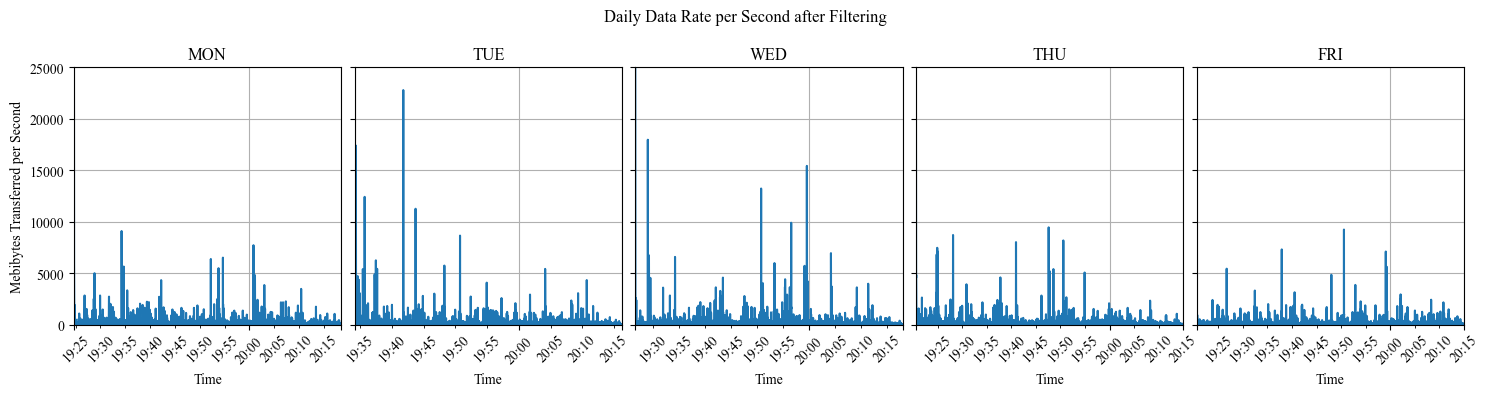

In [76]:
# Sum the bytes for each second, convert to MiB
data_rate_per_second = []
for df in df_filtereds:
    data_rate_per_second.append(df.groupby('start_time_aggr')['bidirectional_bytes'].sum() / 1024 / 1024)


# Plot the data rate
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

for idx, a in enumerate(ax.flatten()):
    data_rate_per_second[idx].plot(kind='line', ax=a)
    a.set_title(days[idx])
    a.set_xlabel('')
    a.set_ylabel('') 
    a.set_ylim(0, 25000)
    a.set_xlabel('Time')
    if idx == 0:
        a.set_ylabel('Mebibytes Transferred per Second')
    a.grid(True)
    a.tick_params(axis='x', which='both', labelrotation=45)
    if idx != 0:
        a.set_yticklabels([])

fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.savefig('plots/preprocessing/data_rates_after_filtering.pdf')
fig.suptitle('Daily Data Rate per Second after Filtering')
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)
plt.show()

The Data Rate got sligthly lower and maintained the same patterns as earlier.

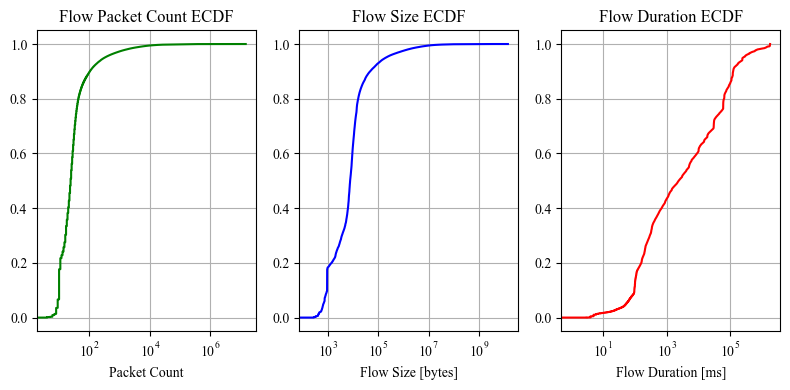

In [77]:
all_df_filtereds = pd.concat(df_filtereds)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))

packet_count_ecdf = ECDF(all_df_filtereds['bidirectional_packets'])
axs[0].plot(packet_count_ecdf.x, packet_count_ecdf.y, color='green', ls='-')
axs[0].set_xscale('log')
axs[0].grid(True)
axs[0].set_xlabel('Packet Count')
axs[0].set_title('Flow Packet Count ECDF')

flow_size_ecdf = ECDF(all_df_filtereds['bidirectional_bytes'])
axs[1].plot(flow_size_ecdf.x, flow_size_ecdf.y, color='blue', ls='-')
axs[1].set_xscale('log')
axs[1].grid(True)
axs[1].set_xlabel('Flow Size [bytes]')
axs[1].set_title('Flow Size ECDF')

flow_duration_ecdf = ECDF(all_df_filtereds['bidirectional_duration_ms'])
axs[2].plot(flow_duration_ecdf.x, flow_duration_ecdf.y, color='red', ls='-')
axs[2].set_xscale('log')
axs[2].grid(True)
axs[2].set_xlabel('Flow Duration [ms]')
axs[2].set_title('Flow Duration ECDF')

plt.tight_layout()
plt.savefig('plots/preprocessing/aggregated_ecdfs_after_filtering.pdf')
plt.show()

We see that by applying the filtering steps the very few packet count flows have dropped out, earlier almost 40% of flows had only 1 packet, now only 20% have less than 10. The flow size also consolidated in a similar manner, only 20% of flows have less than 1 KB of data (before filtering this was around 60%). The same pattern is apparent in flow duration with less than 5% of flows lasting less than 10 ms (opposed to over 40% at the beginning).
The overall pattern of the ECDF plots did not change however, which suggests that by reducing the dataset we managed to retain the main characteristics of the data.

---

## Save the Preprocessed Data

In [78]:
del dfs

In [79]:
import os

path = os.path.join(WD, "preprocessed")

try:
    os.mkdir(path)
except OSError as error:
    print(error)
finally: 
    for day, df in zip(days, df_filtereds):
        df.to_parquet(f'{path}/{day}v1.parquet', index=False)

[WinError 183] Cannot create a file when that file already exists: 'E:/data\\preprocessed'


<hr style="border:5px solid black">

# LAN Delay Characteristics

In [80]:
import statsmodels.api as sm

In [81]:
# Read the datasets (only the columns we will be needing)

dfs = []
for day in days:
    dfs.append(pd.read_parquet(f'{WD}/preprocessed/{day}v1.parquet', columns=['id', 'bidirectional_duration_ms', 'application_name',
                                                                              'application_category_name', 'location', 'connection_type', 
                                                                              'start_second', 'start_time_aggr', 'bidirectional_first_seen_relative_ms',
                                                                              'bidirectional_last_seen_relative_ms', 'bidirectional_packets', 'LAN_delay',
                                                                              'LAN_delay_timestamps', 'LAN_delay_neighboring_PS']))

In [82]:
all_dfs = pd.concat(dfs)

# Coverage

## SPLT coverage

For the early statistical flow analysis the first 255 packets were chosen. This is the default max limit supported by NFStream without the need to modify its source code. We need to quantify whether this limit is enough in order to aptly cover the whole flow. A higher coverage means that even most of the flows are within this limit. This is what we expect from seeing that there is a relatively low number of actively expired long flows.

In order to quantify and visualize this metric we calculate the end of the last LAN delay value (we see no further than this in our analysis), and compare it to the length of the whole flow.

In [83]:
splt_coverage = all_dfs.apply(lambda row: (row['LAN_delay_timestamps'][-1] + row['LAN_delay'][-1] - row['bidirectional_first_seen_relative_ms'])
                                     / row['bidirectional_duration_ms'], axis=1)

C:\Users\Dev\AppData\Local\Temp\ipykernel_4896\2394829697.py:1: RuntimeWarning: invalid value encountered in scalar divide
  splt_coverage = all_dfs.apply(lambda row: (row['LAN_delay_timestamps'][-1] + row['LAN_delay'][-1] - row['bidirectional_first_seen_relative_ms'])


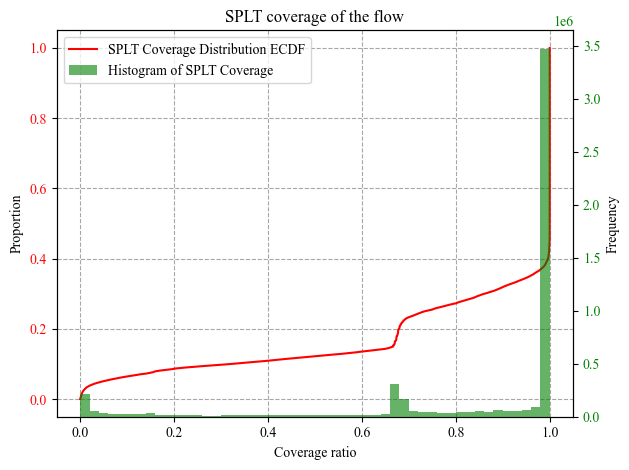

In [84]:
# fig, ax1 = plt.subplots(figsize=(6, 4))
fig, ax1 = plt.subplots()

sc_ecdf = ECDF(splt_coverage)
ax1.plot(sc_ecdf.x, sc_ecdf.y, color='red', ls='-', label="SPLT Coverage Distribution ECDF")
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, which="both", ls="--", c='0.65')
ax1.set_xlabel('Coverage ratio')
ax1.set_ylabel('Proportion')

ax2 = ax1.twinx()
ax2.hist(splt_coverage.to_list(), bins=50, color='green', alpha=0.6, label="Histogram of SPLT Coverage")
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='y', labelcolor='green')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.savefig('plots/delay_analysis/SPLT_coverage_of_flows.pdf')
ax1.set_title('SPLT coverage of the flow')
fig.tight_layout()
plt.show()

The results show that the vast majority of the flows are completely covered by the 255 packets captured by the SPLT analysis. There are a few thousand long flows that do not get complete coverage with a not-insignificant number of flows that are barely covered. However, proportionally these flows account for less than 5% of all flows. Partially covered flows together account for around 30% of all flows, the rest enjoys full or close-to-full coverage.

## LAN coverage

Another coverage metric we can take is examining the summed up time of the LAN delays against the remaining WAN delays in the measured portion.

In [85]:
lan_coverage = all_dfs.apply(lambda row: sum(row['LAN_delay']) 
                                    / (row['LAN_delay_timestamps'][-1] + row['LAN_delay'][-1] - row['bidirectional_first_seen_relative_ms']), axis=1)

C:\Users\Dev\AppData\Local\Temp\ipykernel_4896\2189361677.py:1: RuntimeWarning: invalid value encountered in scalar divide
  lan_coverage = all_dfs.apply(lambda row: sum(row['LAN_delay'])


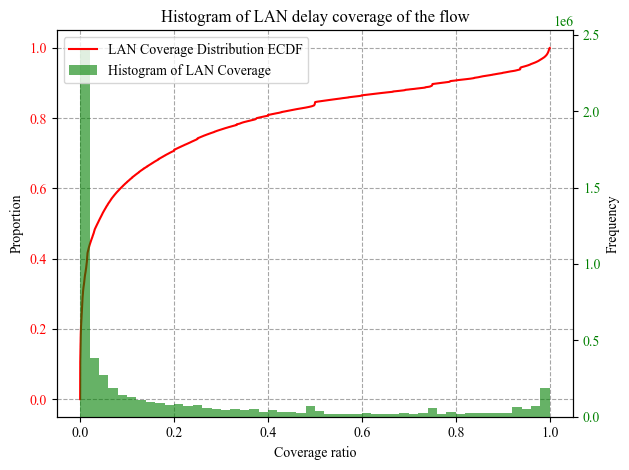

In [86]:
# fig, ax1 = plt.subplots(figsize=(6, 4))
fig, ax1 = plt.subplots()

sc_ecdf = ECDF(lan_coverage)
ax1.plot(sc_ecdf.x, sc_ecdf.y, color='red', ls='-', label="LAN Coverage Distribution ECDF")
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True, which="both", ls="--", c='0.65')
ax1.set_title('Histogram of LAN delay coverage of the flow')
ax1.set_xlabel('Coverage ratio')
ax1.set_ylabel('Proportion')

ax2 = ax1.twinx()
ax2.hist(lan_coverage.to_list(), bins=50, color='green', alpha=0.6, label="Histogram of LAN Coverage")
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='y', labelcolor='green')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.savefig('plots/delay_analysis/LAN_coverage_of_flows.pdf')
plt.show()

We observe that the delays are present in the flows in a smaller proportion than WAN delays overall, with some flows having significantly more LAN delays. For 40% of the flows the LAN delays account for almost none of their overall duration (i.e. they did not experience high LAN-side delays).

## Flows and their LAN delays in time

The figure below represents a sample of a few consecutive flows from the middle of the dataset. In it flow duration is represented by unfilled rectangles. The border color represent the corresponding application category. The rectangles are filled with the LAN delays of the flow with their length representing delay duration and startpoint their timestamp. The coloring is random here and only servers differentiating purposes.

The grey line represents the packet count of each flow on a secondary logarithmic axis.

In [87]:
unique_categories = dfs[0]['application_category_name'].unique()
colors = [
    'steelblue', 'darkorange', 'forestgreen', 'firebrick', 'royalblue',
    'darkred', 'teal', 'indianred', 'dodgerblue', 'darkslategray',
    'olive', 'sienna', 'navy', 'mediumseagreen', 'maroon', 'mediumpurple',
    'dimgray', 'peru', 'cadetblue', 'orangered', 'slategray',
    'olivedrab', 'chocolate', 'midnightblue', 'limegreen', 'saddlebrown',
    'midnightblue', 'slategray'
]
color_map = dict([*zip(list(unique_categories), colors)])

In [88]:
def legend_without_duplicate_labels(ax, *args, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), *args, **kwargs)

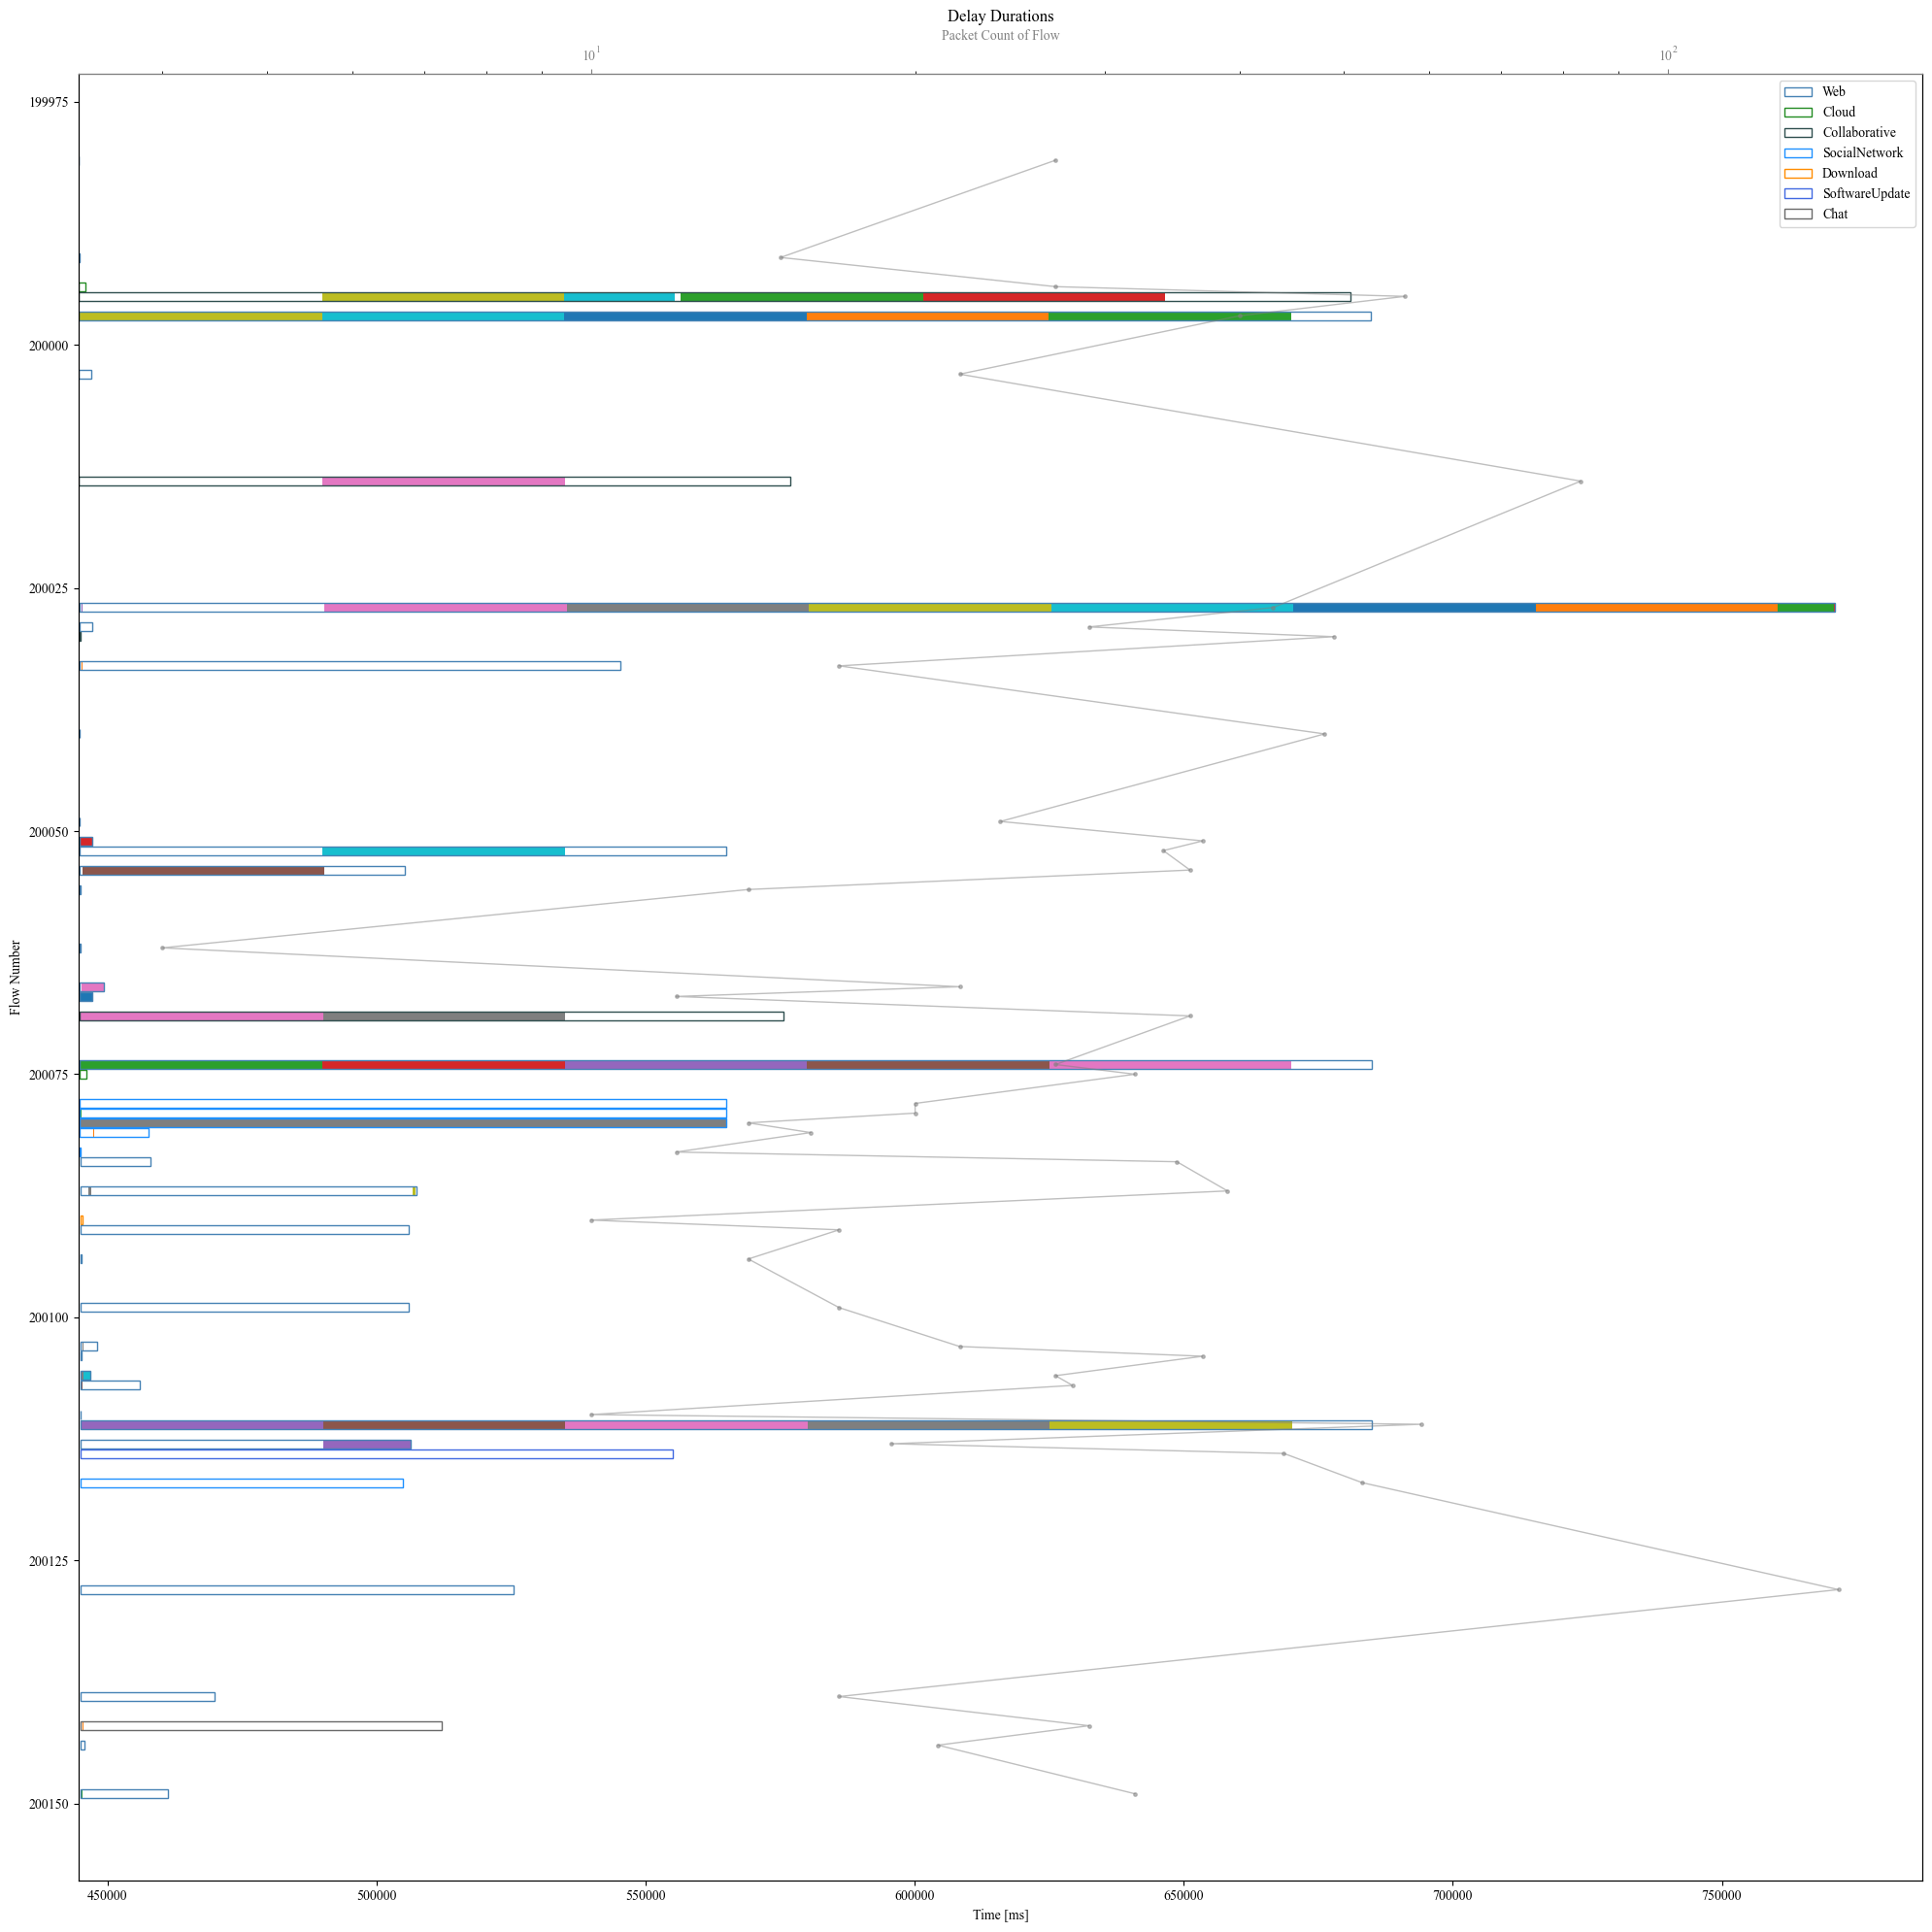

In [89]:
# Focusing on a single location
df_to_plot = dfs[0][dfs[0]['location'].str.startswith('21')].loc[199975:200150]

delays = df_to_plot.apply(lambda row: [(row.name, start, length) for start, length in zip(row['LAN_delay_timestamps'], row['LAN_delay'])], axis=1)

fig, ax = plt.subplots(figsize=(20, 20))
ax_2 = ax.twiny()

for delay_list in delays:
    for idx, start_timestamp, length in delay_list:
        ax.barh(idx, length, height=0.9, left=start_timestamp)

for idx, row in df_to_plot.iterrows():
    ax.barh(idx, row['bidirectional_duration_ms'],
               height=0.9, left=row['bidirectional_first_seen_relative_ms'], align='center',
               edgecolor=color_map[row['application_category_name']], color='none', linewidth=1, label=row['application_category_name']
          )

ax_2.plot(df_to_plot['bidirectional_packets'], df_to_plot.index, color='gray', linewidth=1, alpha=0.5, marker='.', markersize=5)

ax.set_ylabel('Flow Number')
ax.set_xlabel('Time [ms]')
ax.set_title('Delay Durations')
ax.invert_yaxis()
legend_without_duplicate_labels(ax)

ax_2.set_xscale('log')
ax_2.set_xlabel('Packet Count of Flow')
ax_2.spines['top'].set_color('gray')
ax_2.tick_params(axis='x', colors='gray')
ax_2.xaxis.label.set_color('gray')

fig.tight_layout()
plt.show()

We observe that in line with our previous finding there are many flows that either have very short LAN delays (indiscernible in the plot) or these occur at the beginning of the flow with the 255 SPLT limit being too short for them. The grey packet count plot does not back this up. There is no clear correlation between more empty flow in terms of LAN delay and its packet count.

A few flows have longer delays which are clearly marked. Several of them completely cover the whole flow length.

This random sample therefore represents well the extracted LAN delay characteristics and is a good example of the whole dataset.

The differing distance between locations may alter the latency of the measured traffic, therefore, to keep the delays more consistent we are going to focus on *Location 2* in our analysis.

In [90]:
df_l2s = []
for df in tqdm(dfs):
    df_l2 = df[df['location'].str.startswith('2')]
    df_l2s.append(df_l2)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


## Examining Flow Counts

In [91]:
for day, df in zip(days, df_l2s):
    print(day)
    print(f'Flow count: {len(df)}')
    print()

MON
Flow count: 666678

TUE
Flow count: 535622

WED
Flow count: 709312

THU
Flow count: 566524

FRI
Flow count: 470840



The available data should be split into train and test portions during the analysis. The train portion will be used for training models but also for examining data behavior and characterizing the data. This way no information, thus no bias from the test data is used for data tuning resulting in a more true to real-world circumstances scenario.

In [92]:
fc_mon_wed = sum([len(df) for df in df_l2s[:3]])
fc_thu_fri = sum([len(df) for df in df_l2s[3:]])

print(f'Flow count MON-WED: {fc_mon_wed}, percentage: {fc_mon_wed / (fc_mon_wed + fc_thu_fri):.2%}')
print(f'Flow count THU-FRI: {fc_thu_fri}, percentage: {fc_thu_fri / (fc_mon_wed + fc_thu_fri):.2%}')

Flow count MON-WED: 1911612, percentage: 64.82%
Flow count THU-FRI: 1037364, percentage: 35.18%


The data from *Monday* to *Wednesday* takes about 60% of the data, a commonly used split for train data. While the remaining two days will be used for test data.

In [93]:
df_train = df_l2s[:3]
df_test = df_l2s[3:]
df_train_all = pd.concat(df_train)
df_test_all = pd.concat(df_test)

# LAN delay relationship to other features

In [94]:
df_exploded = df_train_all[['application_category_name', 'LAN_delay', 'LAN_delay_neighboring_PS']].explode(['LAN_delay', 'LAN_delay_neighboring_PS']).reset_index()

### Packet Size

#### Pearson and Spearman Correlations

In [95]:
# Calculate Pearson and Spearman correlation coefficients
pearson_corr = df_exploded['LAN_delay'].corr(df_exploded['LAN_delay_neighboring_PS'], method='pearson')
spearman_corr = df_exploded['LAN_delay'].corr(df_exploded['LAN_delay_neighboring_PS'], method='spearman')

pearson_corr, spearman_corr

(-0.16375540569222458, -0.16170014439580016)

The Pearson correlation coefficient between `LAN_delay` and `LAN_delay_neighboring_PS` is approximately $-0.163$ the Spearman correlation coefficient is approximately $-0.161$

Both coefficients are negative, suggesting a weak inverse relationship: as the packet size increases, the delay tends to decrease slightly. However, the correlation is weak, indicating that the linear or monotonic relationship is not strong.

#### Linear regression model

In [96]:
# Drop rows with missing values
df_clean = df_exploded.dropna(subset=['LAN_delay', 'LAN_delay_neighboring_PS'])

# Ensure data types are numeric
df_clean['LAN_delay'] = pd.to_numeric(df_clean['LAN_delay'], errors='coerce')
df_clean['LAN_delay_neighboring_PS'] = pd.to_numeric(df_clean['LAN_delay_neighboring_PS'], errors='coerce')

# Drop any further rows with missing values after coercion
df_clean = df_clean.dropna(subset=['LAN_delay', 'LAN_delay_neighboring_PS'])

In [97]:
# Simple linear regression model
X = df_clean['LAN_delay_neighboring_PS']
y = df_clean['LAN_delay']
X = sm.add_constant(X)  # Add a constant term to the predictor

model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              LAN_delay   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 4.393e+05
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:37:36   Log-Likelihood:            -1.6873e+08
No. Observations:            15942502   AIC:                         3.375e+08
Df Residuals:                15942500   BIC:                         3.375e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<font color='red'>Despite the statistical significance of the regression model (as indicated by the F-statistic and low p-values), the low R-squared value suggests that the packet size does not explain much of the variability in delay.</font>

#### Scatter plot of values

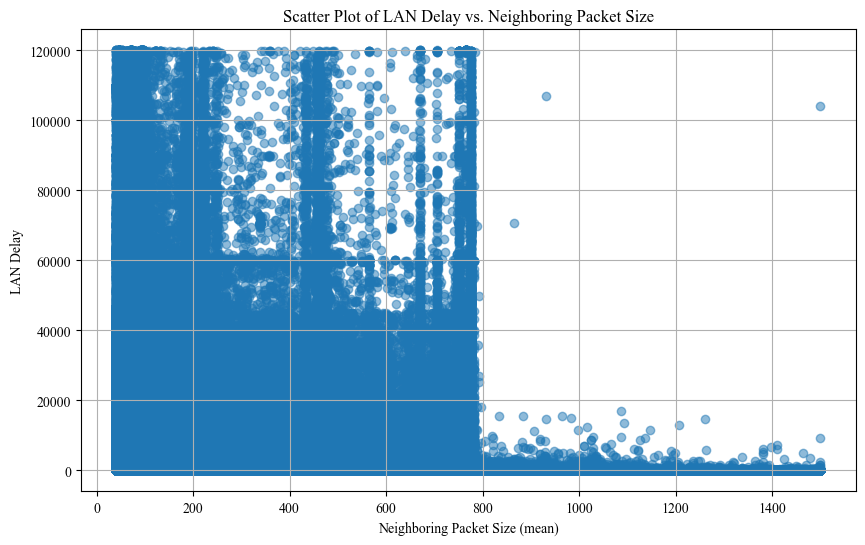

In [98]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_exploded['LAN_delay_neighboring_PS'], df_exploded['LAN_delay'], alpha=0.5)
plt.title('Scatter Plot of LAN Delay vs. Neighboring Packet Size')
plt.xlabel('Neighboring Packet Size (mean)')
plt.ylabel('LAN Delay')
plt.grid(True)
plt.savefig('plots/delay_analysis/PSvdelay.png', dpi=500)
plt.show()

The scatterplot shows that if the packet size is small the LAN delay shows high volatility. With increasing packet size the delay tends to be smaller.

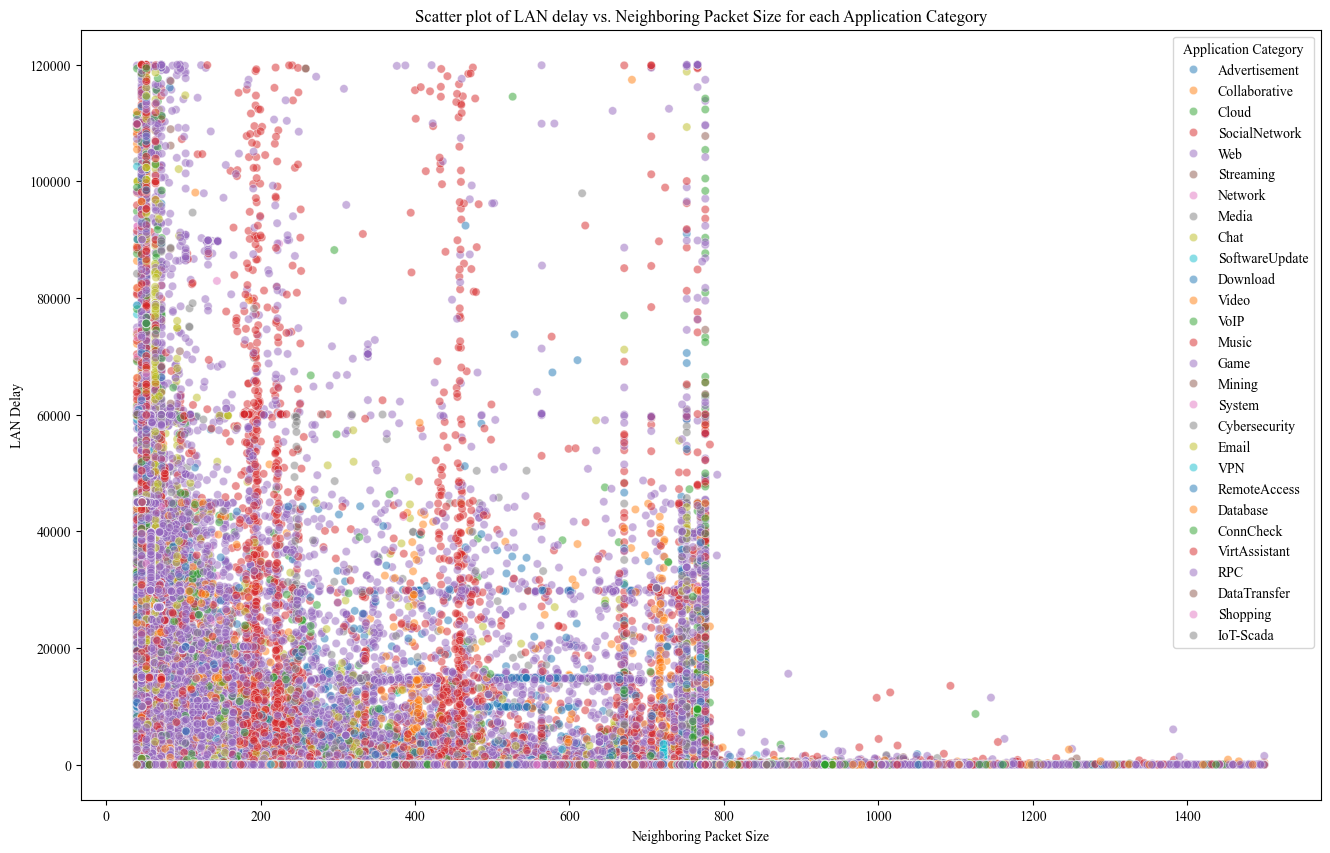

In [99]:
# Scatter plot of LAN_delay against LAN_delay_neighboring_PS for each application category
plt.figure(figsize=(16, 10))
sns.scatterplot(x='LAN_delay_neighboring_PS', y='LAN_delay', hue='application_category_name', 
                data=df_exploded.sample(frac=0.1, random_state=1), alpha=0.5, palette='tab10')

plt.title('Scatter plot of LAN delay vs. Neighboring Packet Size for each Application Category')
plt.xlabel('Neighboring Packet Size')
plt.ylabel('LAN Delay')
plt.legend(title='Application Category')
plt.savefig('plots/delay_analysis/PSvdelay_with_appcats.png', dpi=500)
plt.show()

Coloring by application category (only 10% of the data is shown in order to curb execution time) does not clearly indicate any pattern that can be observed by filtering by application category. To take a clearer picture we plot a scatterplot for each application category separately.

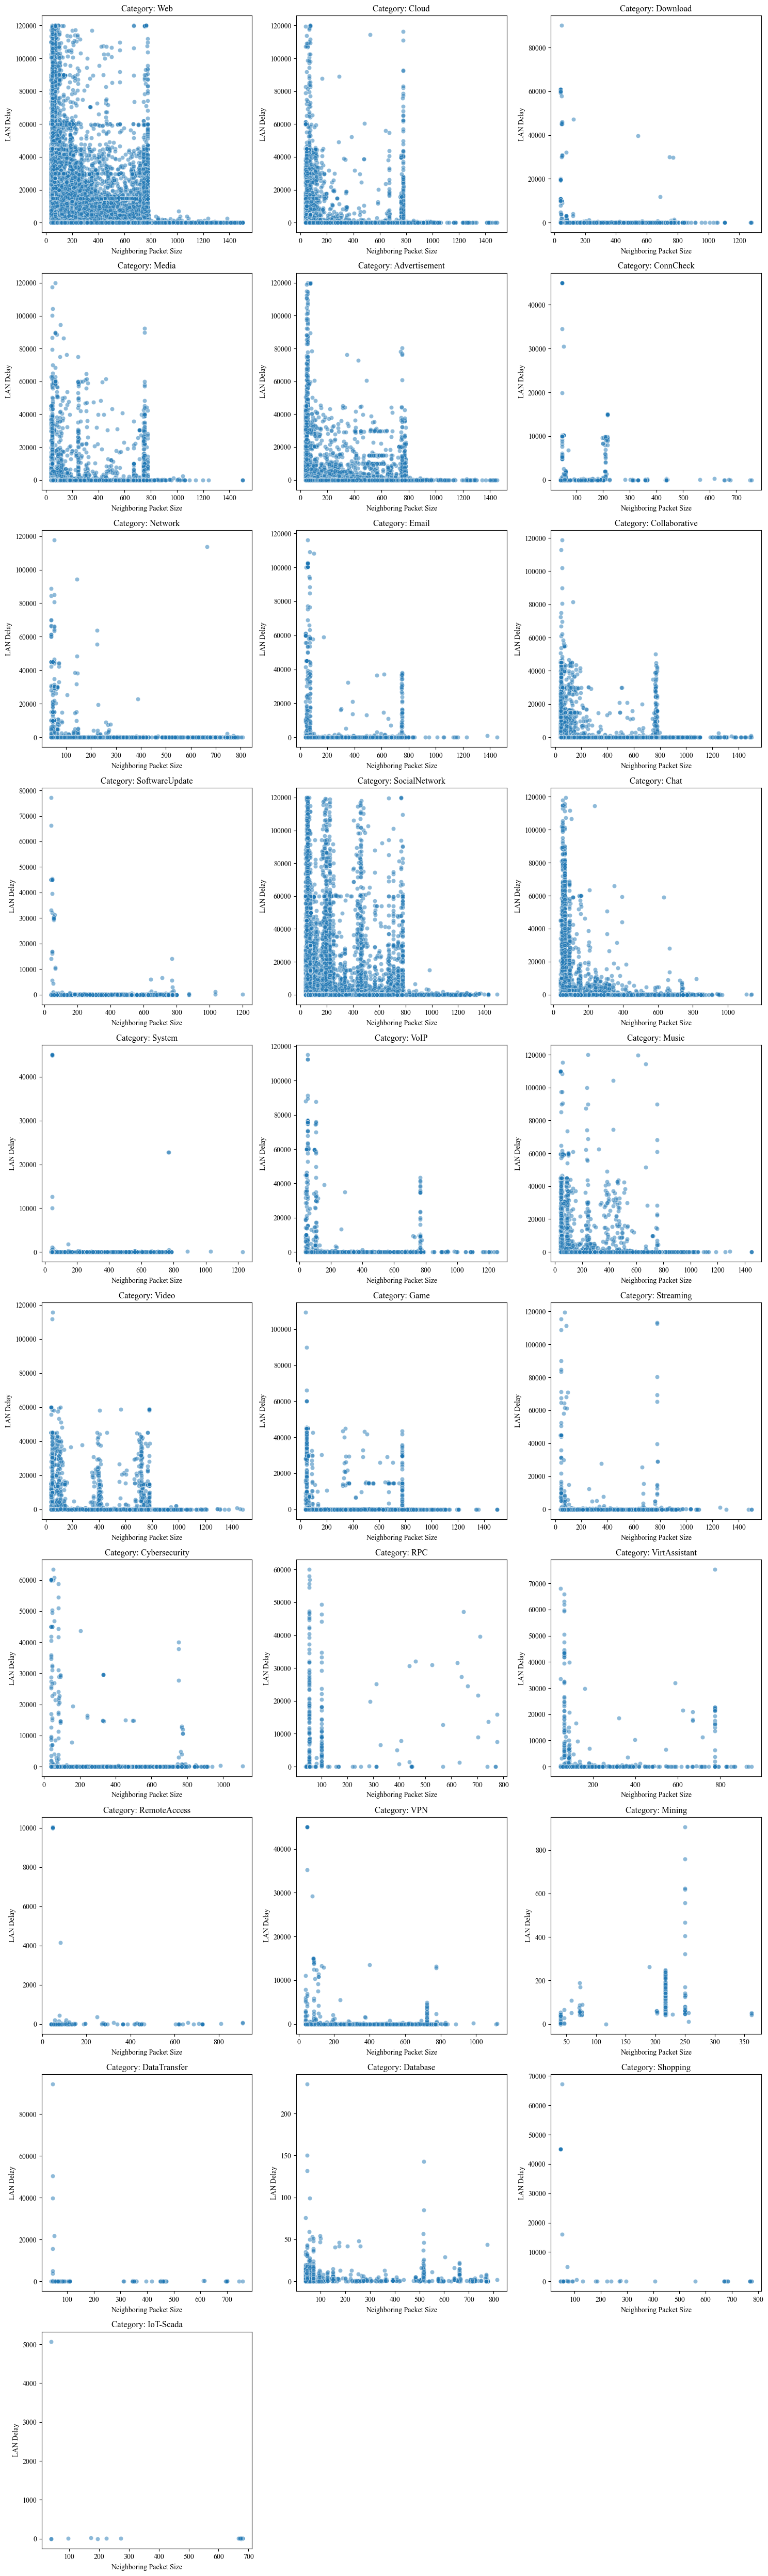

In [100]:
# Unique application categories
categories = df_exploded['application_category_name'].unique()

# Determine the number of rows and columns for the grid
n_cols = 3  # You can adjust this as needed
n_rows = int(np.ceil(len(categories) / n_cols))

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Create a scatter plot for each category
for i, category in enumerate(categories):
    ax = axes[i]
    data = df_exploded[df_exploded['application_category_name'] == category].sample(frac=0.1, random_state=1)
    sns.scatterplot(x='LAN_delay_neighboring_PS', y='LAN_delay', data=data, ax=ax, alpha=0.5)
    ax.set_title(f'Category: {category}')
    ax.set_xlabel('Neighboring Packet Size')
    ax.set_ylabel('LAN Delay')

# Remove any empty subplots
for i in range(len(categories), n_cols * n_rows):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We still do not observe any linear relationship between neighboring packet size and LAN delay in non of the application categries. Most plots share the same characteristics as the previous combined plots. Some categries have consistently low packet sizes. Some have packet sizes with great variability even with a consistent low LAN delay in the flows.

### Application Category

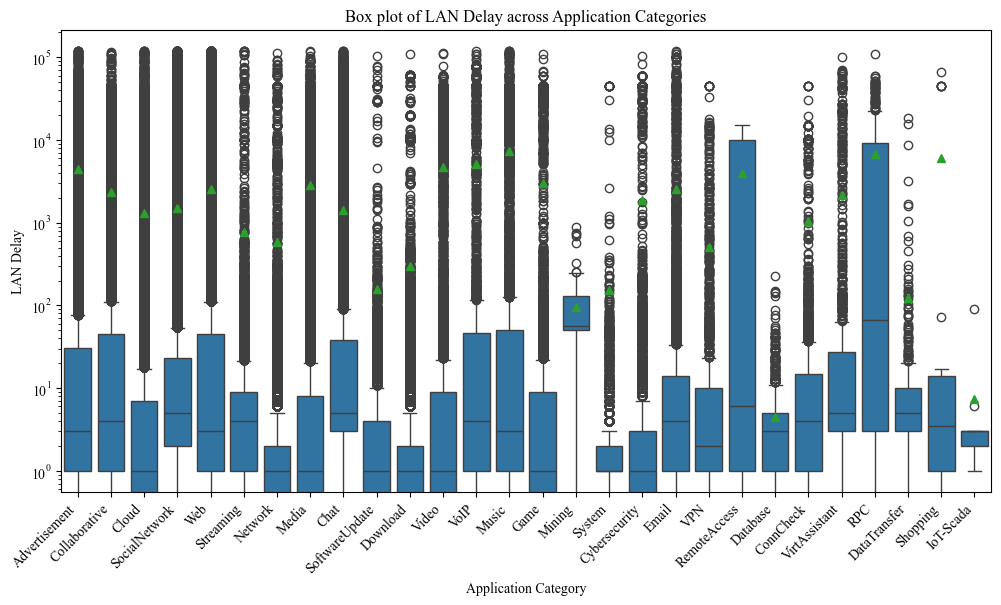

In [101]:
# Box plot of LAN_delay across different application categories
plt.figure(figsize=(12, 6))
sns.boxplot(x='application_category_name', y='LAN_delay', data=df_exploded.sample(frac=0.1, random_state=1), showmeans=True)
plt.title('Box plot of LAN Delay across Application Categories')
plt.xlabel('Application Category')
plt.ylabel('LAN Delay')
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.savefig('plots/delay_analysis/LAN_delay_per_app_boxplot.pdf')
plt.show()

The application category does appear to influence the LAN delay with a separate distribution for each of them. This feature may be useful to be included for both intra- (in the same flow) and inter-flow LAN delay and service degradation prediciton.

*We explore this relationship in more detail in the **Notebook: Identifying Service Degradation***.

### Jitter

Jitter is absolute pair-wise difference of the delays and it describes variance of delay. A high jitter indicates that the delay value changed abruptly. Ususally instead of a point-by-point value, the average jitter in a time window is given.

In this section we study the connection between this value and the delay.

#### Point-wise Comparison

<font color='gray'>Note: *In order to compare the jitter with delay we need to have two lists of values of the same length. Jitter is a shorter list, since the very first delay has nothing to compare it to. Here we artificially insert a jitter of 0.*</font>

In [102]:
for df in df_train:
    df['LAN_jitter'] = df['LAN_delay'].apply(lambda x: [0] + [np.abs(x[i] - x[i-1]) for i in range(1, len(x))])  # adding a 0 so that the correlation comparison can be carried out

C:\Users\Dev\AppData\Local\Temp\ipykernel_11964\197572294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAN_jitter'] = df['LAN_delay'].apply(lambda x: [0] + [np.abs(x[i] - x[i-1]) for i in range(1, len(x))])  # adding a 0 so that the correlation comparison can be carried out
C:\Users\Dev\AppData\Local\Temp\ipykernel_11964\197572294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LAN_jitter'] = df['LAN_delay'].apply(lambda x: [0] + [np.abs(x[i] - x[i-1]) for i in range(1, len(x))])  # addin

In [103]:
df_train_all = pd.concat(df_train)

In [104]:
df_exploded = df_train_all[['application_category_name', 'LAN_delay', 'LAN_jitter']].explode(['LAN_delay', 'LAN_jitter']).reset_index()

**Pearson and Spearman correlation**

In [105]:
# Calculate Pearson and Spearman correlation coefficients
pearson_corr = df_exploded['LAN_delay'].corr(df_exploded['LAN_jitter'], method='pearson')
spearman_corr = df_exploded['LAN_delay'].corr(df_exploded['LAN_jitter'], method='spearman')

pearson_corr, spearman_corr

(0.5039221045678471, 0.5732521729265481)

A Pearson Correlation of $0.504$ and a Spearman Correlation of $0.573$ both indicate a moderate positive linear relationship. As `LAN_jitter` increases, `LAN_delay` tends to increase as well. The Spearman correlation tells us that this increase is mostly monotonic.

**Linear regression model**

In [106]:
# Drop rows with missing values
df_clean = df_exploded.dropna(subset=['LAN_delay', 'LAN_jitter'])

# Ensure data types are numeric
df_clean['LAN_delay'] = pd.to_numeric(df_clean['LAN_delay'], errors='coerce')
df_clean['LAN_jitter'] = pd.to_numeric(df_clean['LAN_jitter'], errors='coerce')

# Drop any further rows with missing values after coercion
df_clean = df_clean.dropna(subset=['LAN_delay', 'LAN_jitter'])

In [107]:
# Simple linear regression model
X = df_clean['LAN_jitter']
y = df_clean['LAN_delay']
X = sm.add_constant(X)  # Add a constant term to the predictor

model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              LAN_delay   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                 5.426e+06
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:56:06   Log-Likelihood:            -1.6662e+08
No. Observations:            15942502   AIC:                         3.332e+08
Df Residuals:                15942500   BIC:                         3.332e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1270.4136      2.146    591.869      0.0

The model suggests a weak but statistically significant (high f-value) linear relationship between LAN_jitter and LAN_delay. An R-squared of 0.254 (meaning that 25.4% of the variance in LAN_delay is explained by LAN_jitter), there is still a substantial amount of variability in LAN_delay that is not explained by LAN_jitter alone.

**Scatterplot of the relationship**

C:\Users\Dev\AppData\Local\Temp\ipykernel_11964\2572514550.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots/delay_analysis/jittervdelay_with_appcats.png', dpi=500)
C:\Users\Dev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


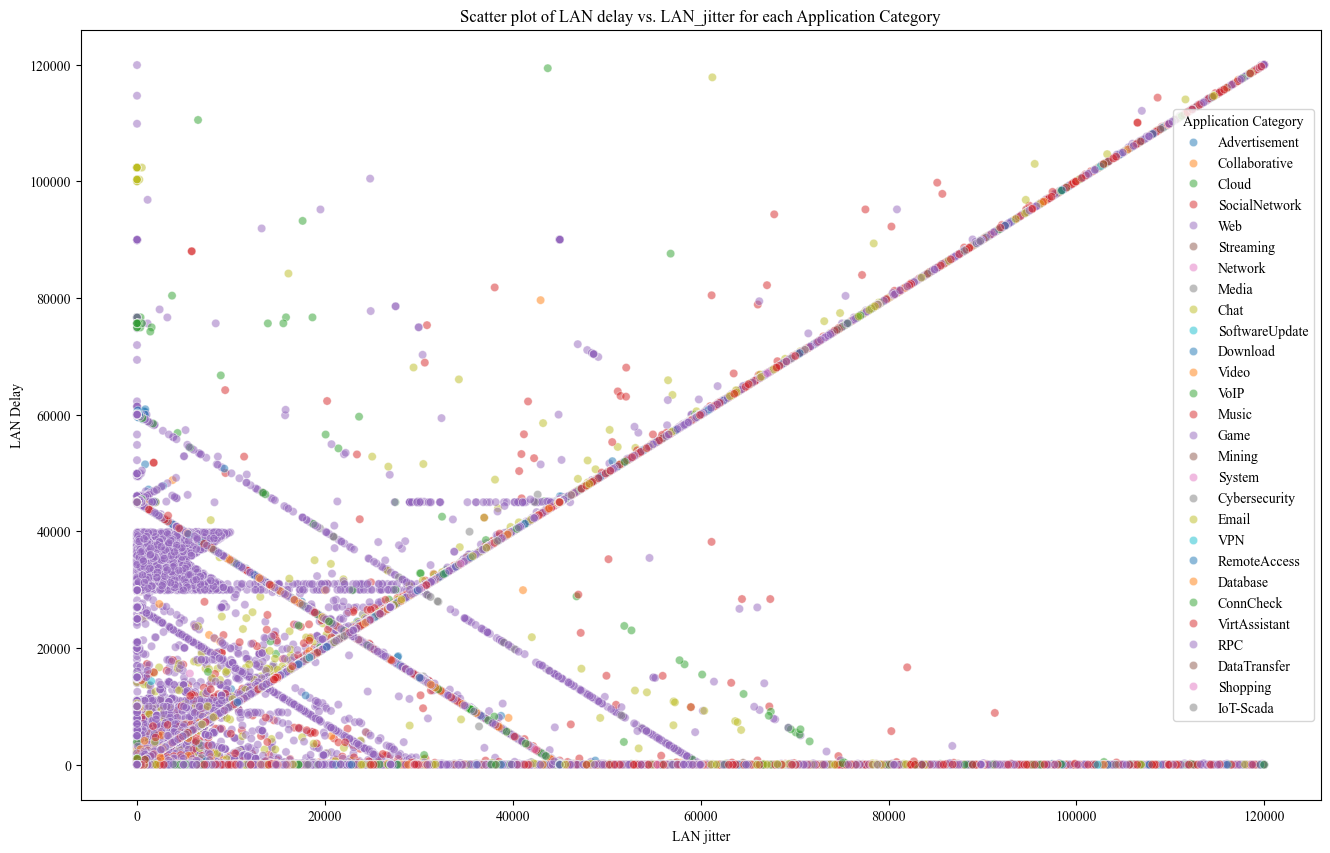

In [108]:
# Scatter plot of LAN_delay against LAN_delay_neighboring_PS for each application category
plt.figure(figsize=(16, 10))
sns.scatterplot(x='LAN_jitter', y='LAN_delay', hue='application_category_name', 
                data=df_exploded.sample(frac=0.1, random_state=1), alpha=0.5, palette='tab10')

plt.title('Scatter plot of LAN delay vs. LAN_jitter for each Application Category')
plt.xlabel('LAN jitter')
plt.ylabel('LAN Delay')
plt.legend(title='Application Category')
plt.savefig('plots/delay_analysis/jittervdelay_with_appcats.png', dpi=500)
plt.show()

We can observe some patterns in the scatterplot of the LAN delay and LAN jitter values. There are some clear linear relationship patterns. Some report that as LAN delay increases, the jitter does too while others indicate an inverse relationship.

On the left side of the plot there are delays with lower jitter. The majority of the delay-jitter pairs seem to be located here, indicating flows with stable delay values.

Before we plotted individual delays, however, it prove more insightful to plot one datapoint per flow of the connection between average delay and jitter for the whole flow.

#### Average Delay and Jitter Relationship

In [109]:
df_train_all['Avg delay'] = df_train_all['LAN_delay'].apply(lambda x: np.mean(x))
df_train_all['Avg jitter'] = df_train_all['LAN_jitter'].apply(lambda x: np.std(x))

C:\Users\Dev\AppData\Local\Temp\ipykernel_11964\2415645524.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots/delay_analysis/avgjitter_v_avgdelay_with_appcats.png', dpi=500)
C:\Users\Dev\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


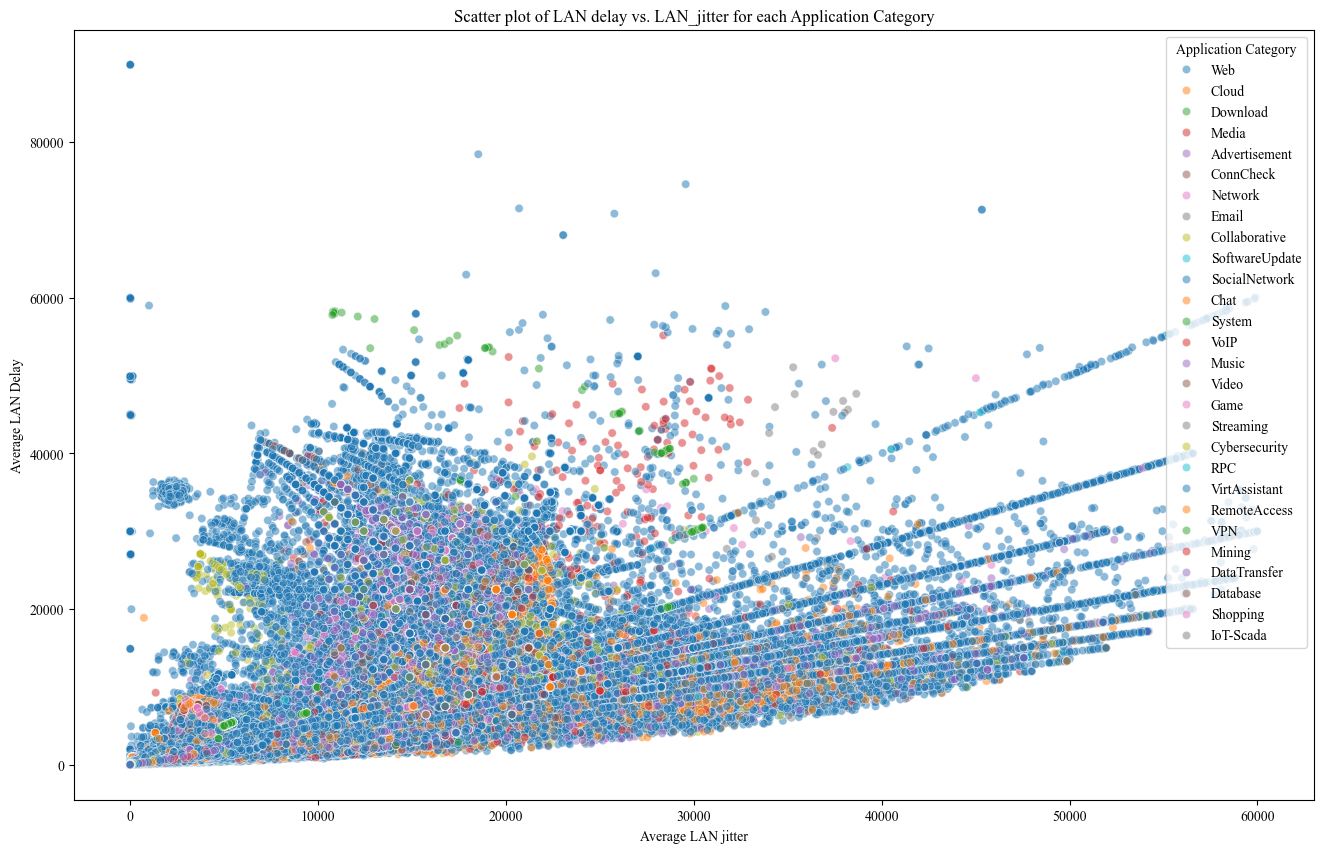

In [110]:
# Scatter plot of LAN_delay against LAN_delay_neighboring_PS for each application category
plt.figure(figsize=(16, 10))
sns.scatterplot(x='Avg jitter', y='Avg delay', hue='application_category_name', 
                data=df_train_all, alpha=0.5, palette='tab10')

plt.title('Scatter plot of LAN delay vs. LAN_jitter for each Application Category')
plt.xlabel('Average LAN jitter')
plt.ylabel('Average LAN Delay')
plt.legend(title='Application Category')
plt.savefig('plots/delay_analysis/avgjitter_v_avgdelay_with_appcats.png', dpi=500)
plt.show()

We see similar patterns in this plot as well with some linear relationships. Some flows appear to follow parabolic curves as well in their delay-jitter relationship. The number of flows that observe constant jitter proves to be quite low. This indicates variability in the LAN delay samples of the flows.

Overall, jitter does seem to influence delay for some flows and therefore it may prove beneficial to include in prediction models.

---

In [111]:
for df in tqdm(dfs):
    df['LAN_jitter'] = df['LAN_delay'].apply(lambda x: [0] + [np.abs(x[i] - x[i-1]) for i in range(1, len(x))])  # adding a 0 so that the correlation comparison can be carried out

In [112]:
import os

path = os.path.join(WD, "preprocessed")

try:
    os.mkdir(path)
except OSError as error:
    print(error)
finally: 
    for day, df in zip(days, dfs):
        df.to_parquet(f'{path}/{day}v2.parquet', index=False)